Fitted params from 0A (HQ874 baseline):
  H: eps = 1.356e-06 m·rad, sigma_delta = 8.543e-04
  V: eps = 1.063e-06 m·rad, sigma_delta = 0.000e+00 (expect ~0)

Files used:
  HQ874 -45A -> twiss_Q874_baseline_-45a_flipPol.tfs
  HQ874 -36A -> twiss_Q874_baseline_-36a_flipPol.tfs
  HQ874 -27A -> twiss_Q874_baseline_-27a_flipPol.tfs
  HQ874 -18A -> twiss_Q874_baseline_-18a_flipPol.tfs
  HQ874 -9A -> twiss_Q874_baseline_-9a_flipPol.tfs
  HQ874 Baseline -> twiss_Q874_baseline_flipPol.tfs
  HQ874 +9A -> twiss_Q874_baseline_+9a_flipPol.tfs
  HQ874 +18A -> twiss_Q874_baseline_+18a_flipPol.tfs
  HQ874 +23.8A -> twiss_Q874_baseline_+23.8a_flipPol.tfs
  HQ874 +27A -> twiss_Q874_baseline_+27a_flipPol.tfs


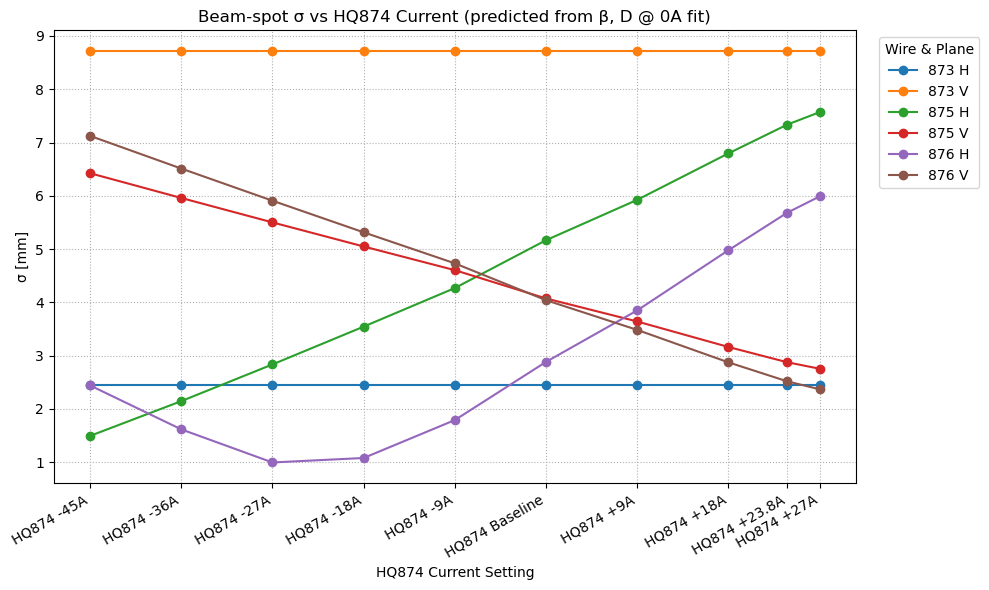


Wrote madx_pred_sigma_vs_current_HQ874_flipPol.csv


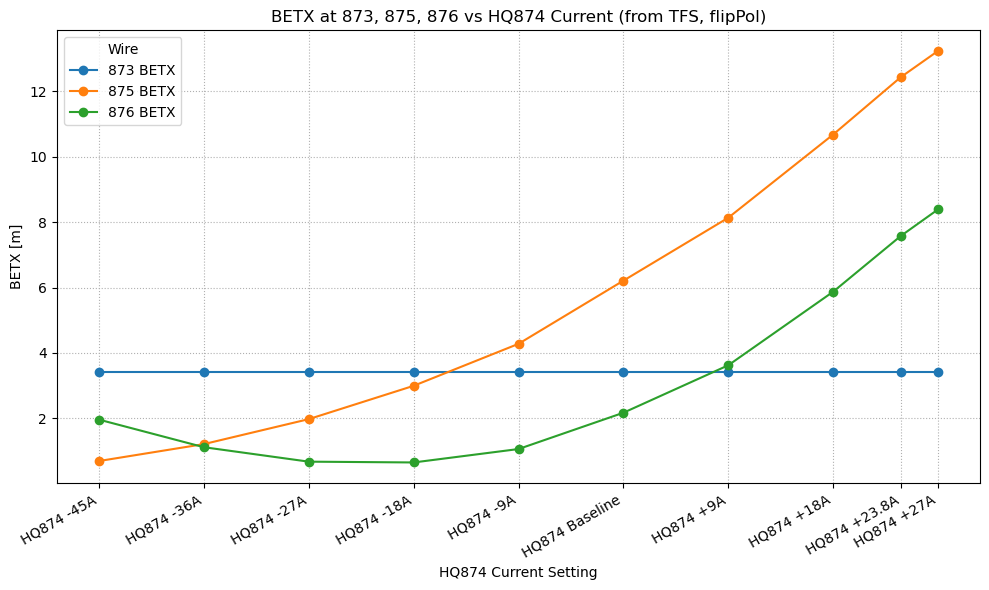

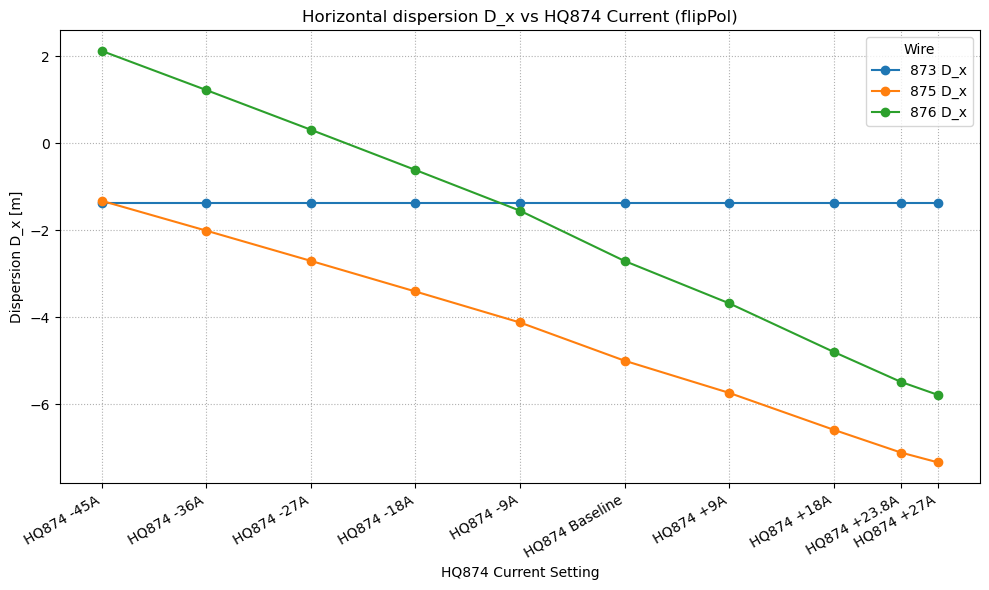

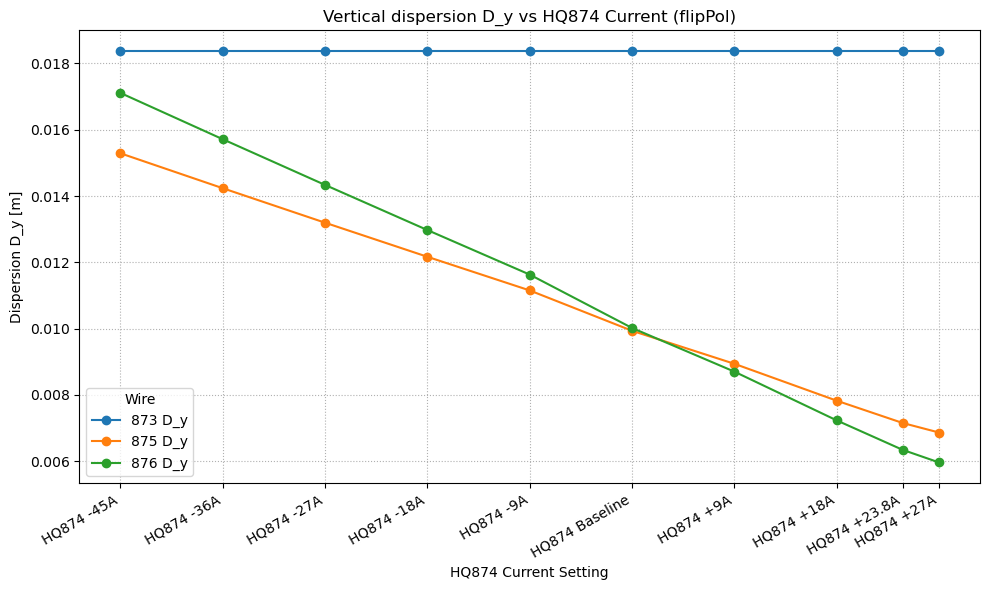

Wrote betax_vs_HQ874_current_flipPol.csv and dispersion_vs_HQ874_current_flipPol.csv


In [1]:
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# Config: magnet labels + where to look for files
#   - MAGNET_FILE_TAG must match filenames (files use "Q874")
#   - MAGNET_LABEL is what shows up on plots ("HQ874" per note)
# =============================================================================
MAGNET_FILE_TAG = "Q874"
MAGNET_LABEL    = "HQ874"
USE_FLIPPED     = True  # we're using *_flipPol.tfs

# If needed, adjust which wires we care about and the baseline measured σ (mm)
# (These are placeholders carried from Q873 script; replace with HQ874 numbers if different.)
monitors = ["MW873","MW875","MW876"]
baseline_measured_mm = {
    ("MW873","H"): 2.30, ("MW873","V"): 5.00,
    ("MW875","H"): 5.00, ("MW875","V"): 1.37,
    ("MW876","H"): 3.77, ("MW876","V"): 0.969,
}

# =============================================================================
# Discover available HQ874 files in the current directory
# Expected new pattern examples:
#   twiss_Q874_baseline_flipPol.tfs               -> baseline (0 A)
#   twiss_Q874_baseline_-45a_flipPol.tfs          -> -45 A
#   twiss_Q874_baseline_+23.8a_flipPol.tfs        -> +23.8 A
# Also tolerate a couple of legacy alternates for safety.
# =============================================================================
def discover_q874_files(use_flipped=True):
    files = {}
    entries = os.listdir(".")
    # Primary (new) patterns
    base_pat = rf"^twiss_{MAGNET_FILE_TAG}_baseline(_(?P<curr>[+-]?\d+(?:\.\d+)?)a)?_flipPol\.tfs$" if use_flipped \
               else rf"^twiss_{MAGNET_FILE_TAG}_baseline(_(?P<curr>[+-]?\d+(?:\.\d+)?)a)?\.tfs$"
    base_rx = re.compile(base_pat, re.IGNORECASE)

    for name in entries:
        m = base_rx.match(name)
        if m:
            curr = m.group("curr")
            key = "0" if curr is None else curr  # keep as string, may be decimal
            files[key] = name

    # Legacy fallbacks (rare): twiss_Q874_+9A_flipPol.tfs, twiss_Q874_default.tfs, etc.
    if "0" not in files:
        for nm in entries:
            if re.fullmatch(rf"twiss_{MAGNET_FILE_TAG}_default\.tfs", nm, re.IGNORECASE):
                files["0"] = nm
                break
    legacy_rx = re.compile(
        rf"^twiss_{MAGNET_FILE_TAG}_(?P<curr>[+-]?\d+(?:\.\d+)?)[aA]_flipPol\.tfs$", re.IGNORECASE
    )
    for nm in entries:
        m = legacy_rx.match(nm)
        if m:
            key = m.group("curr")
            files.setdefault(key, nm)

    if not files:
        raise RuntimeError("No HQ874 (Q874) twiss files found in the current directory.")

    return files

files = discover_q874_files(USE_FLIPPED)

# =============================================================================
# Utilities
# =============================================================================
def label_for_key(key: str) -> str:
    if key == "0":
        return f"{MAGNET_LABEL} Baseline"
    return f"{MAGNET_LABEL} {key}A"

def order_keys_numeric(keys):
    # sort by numeric current (baseline "0" becomes 0.0)
    def k2f(k): 
        try: return float(k)
        except: return 0.0
    return sorted(keys, key=k2f)

# Robust TFS reader (same as before)
def read_tfs(path):
    if not path or not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header_idx = None
    for i, ln in enumerate(lines):
        if ln.lstrip().startswith("*"):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError(f"No '*' header line in {path}")

    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()

    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1

    data_rows = []
    for ln in lines[start:]:
        if ln.strip() == "" or ln.lstrip().startswith(("@","#","*","$")):
            continue
        data_rows.append(ln)

    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=[c.upper() for c in cols], engine="python")

    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            existing = df[df["NAME"].str.contains("MW", na=False)]["NAME"].unique()
            raise RuntimeError(f"{w} not found. MW-like names present: {existing[:10]}")
        out[w] = m.iloc[0]
    return out

def fit_plane_params(baseline_rows, plane):
    beta_col = "BETX" if plane=="H" else "BETY"
    disp_col = "DX"   if plane=="H" else "DY"

    y, X = [], []
    for w in monitors:
        sig_mm = baseline_measured_mm[(w,plane)]
        sig2_m2 = (sig_mm*1e-3)**2
        beta = float(baseline_rows[w][beta_col])
        disp = float(baseline_rows[w][disp_col])
        y.append(sig2_m2)
        X.append([beta, disp*disp])

    y = np.array(y); X = np.array(X)
    p, *_ = np.linalg.lstsq(X, y, rcond=None)  # [ε, σδ^2]
    eps, sdel2 = float(p[0]), float(p[1])
    return max(eps,0.0), max(sdel2,0.0)

# =============================================================================
# Load baseline (0 A), fit ε, σδ, then sweep all discovered settings
# =============================================================================
if "0" not in files:
    raise RuntimeError("Baseline (0 A) file not found. Expect twiss_Q874_baseline_flipPol.tfs")

df0 = read_tfs(files["0"])
rows0 = get_mw_rows(df0)

eps_x, sdel2_x = fit_plane_params(rows0, "H")
eps_y, sdel2_y = fit_plane_params(rows0, "V")

print(f"Fitted params from 0A ({MAGNET_LABEL} baseline):")
print(f"  H: eps = {eps_x:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_x):.3e}")
print(f"  V: eps = {eps_y:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_y):.3e} (expect ~0)")

sigma_pred = { (w,"H"):[] for w in monitors }
sigma_pred.update({ (w,"V"):[] for w in monitors })
betx = { w:[] for w in monitors }
dx   = { w:[] for w in monitors }
dy   = { w:[] for w in monitors }

labels_available = []
files_used = []

ordered_keys = order_keys_numeric(files.keys())
for key in ordered_keys:
    path = files[key]
    if not path or not os.path.exists(path):
        print(f"Skipping (missing): {key} -> {path}")
        continue

    df = read_tfs(path)
    rows = get_mw_rows(df)
    labels_available.append(key)
    files_used.append((key, path))

    for w in monitors:
        bx  = float(rows[w]["BETX"]); ddx = float(rows[w]["DX"])
        by  = float(rows[w]["BETY"]); ddy = float(rows[w]["DY"])

        sig_h_mm = math.sqrt(eps_x*bx + sdel2_x*(ddx**2)) * 1e3
        sig_v_mm = math.sqrt(eps_y*by + sdel2_y*(ddy**2)) * 1e3

        sigma_pred[(w,"H")].append(sig_h_mm)
        sigma_pred[(w,"V")].append(sig_v_mm)

        betx[w].append(bx)
        dx[w].append(ddx)
        dy[w].append(ddy)

print("\nFiles used:")
for k, p in files_used:
    print(f"  {label_for_key(k)} -> {p}")

# X axis
xs = np.array([float(k) for k in labels_available])
xtick_labels = [label_for_key(k) for k in labels_available]

# =============================================================================
# σ vs current (prediction)
# =============================================================================
plt.figure(figsize=(10,6))
plot_order = [("MW873","H"),("MW873","V"),
              ("MW875","H"),("MW875","V"),
              ("MW876","H"),("MW876","V")]
# Only plot those that exist in 'monitors'
plot_order = [kp for kp in plot_order if kp[0] in monitors]

for key in plot_order:
    y = sigma_pred[key]
    label = f"{key[0][-3:]} {key[1]}"
    plt.plot(xs, y, marker="o", label=label)

plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting")
plt.ylabel("σ [mm]")
plt.title(f"Beam-spot σ vs {MAGNET_LABEL} Current (predicted from β, D @ 0A fit)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire & Plane", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Save CSV
pred_cols = {f"{w} {p}": sigma_pred[(w,p)] for w in monitors for p in ("H","V")}
pred_df = pd.DataFrame(pred_cols, index=xtick_labels)
pred_df.to_csv(f"madx_pred_sigma_vs_current_{MAGNET_LABEL}_flipPol.csv")
print(f"\nWrote madx_pred_sigma_vs_current_{MAGNET_LABEL}_flipPol.csv")

# =============================================================================
# BETX vs current
# =============================================================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, betx[w], marker="o", label=f"{w[-3:]} BETX")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting")
plt.ylabel("BETX [m]")
plt.title(f"BETX at {', '.join(m[-3:] for m in monitors)} vs {MAGNET_LABEL} Current (from TFS, flipPol)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# =============================================================================
# Dispersion Dx / Dy vs current
# =============================================================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dx[w], marker="o", label=f"{w[-3:]} D_x")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting")
plt.ylabel("Dispersion D_x [m]")
plt.title(f"Horizontal dispersion D_x vs {MAGNET_LABEL} Current (flipPol)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dy[w], marker="o", label=f"{w[-3:]} D_y")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting")
plt.ylabel("Dispersion D_y [m]")
plt.title(f"Vertical dispersion D_y vs {MAGNET_LABEL} Current (flipPol)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# Save optics/dispersion CSVs
pd.DataFrame({w: betx[w] for w in monitors}, index=xtick_labels)\
  .to_csv(f"betax_vs_{MAGNET_LABEL}_current_flipPol.csv")
pd.DataFrame({**{f"{w} D_x": dx[w] for w in monitors},
               **{f"{w} D_y": dy[w] for w in monitors}},
             index=xtick_labels)\
  .to_csv(f"dispersion_vs_{MAGNET_LABEL}_current_flipPol.csv")
print(f"Wrote betax_vs_{MAGNET_LABEL}_current_flipPol.csv and dispersion_vs_{MAGNET_LABEL}_current_flipPol.csv")


Fitted params from 0A baseline (twiss_Q874_baseline_flipPol.tfs):
  H: eps = 1.356e-06 m·rad, sigma_delta = 8.543e-04
  V: eps = 1.063e-06 m·rad, sigma_delta = 0.000e+00 (expect ~0)

Files used (sweep):
  HQ874 -45A -> twiss_Q874_baseline_-45a_posPol.tfs
  HQ874 -36A -> twiss_Q874_baseline_-36a_posPol.tfs
  HQ874 -35A -> twiss_Q874_baseline_-35a_posPol.tfs
  HQ874 -27A -> twiss_Q874_baseline_-27a_posPol.tfs
  HQ874 -18A -> twiss_Q874_baseline_-18a_posPol.tfs
  HQ874 -9A -> twiss_Q874_baseline_-9a_posPol.tfs
  HQ874 +9A -> twiss_Q874_baseline_+9a_posPol.tfs
  HQ874 +18A -> twiss_Q874_baseline_+18a_posPol.tfs
  HQ874 +23.8A -> twiss_Q874_baseline_+23.8a_posPol.tfs
  HQ874 +27A -> twiss_Q874_baseline_+27a_posPol.tfs
Baseline file: twiss_Q874_baseline_flipPol.tfs


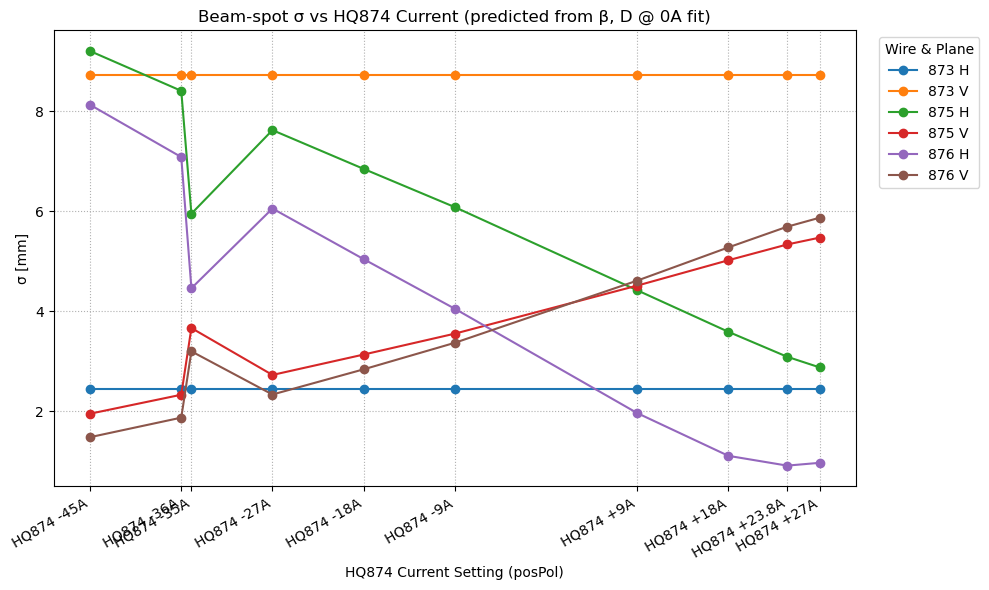


Wrote madx_pred_sigma_vs_current_HQ874_posPol.csv


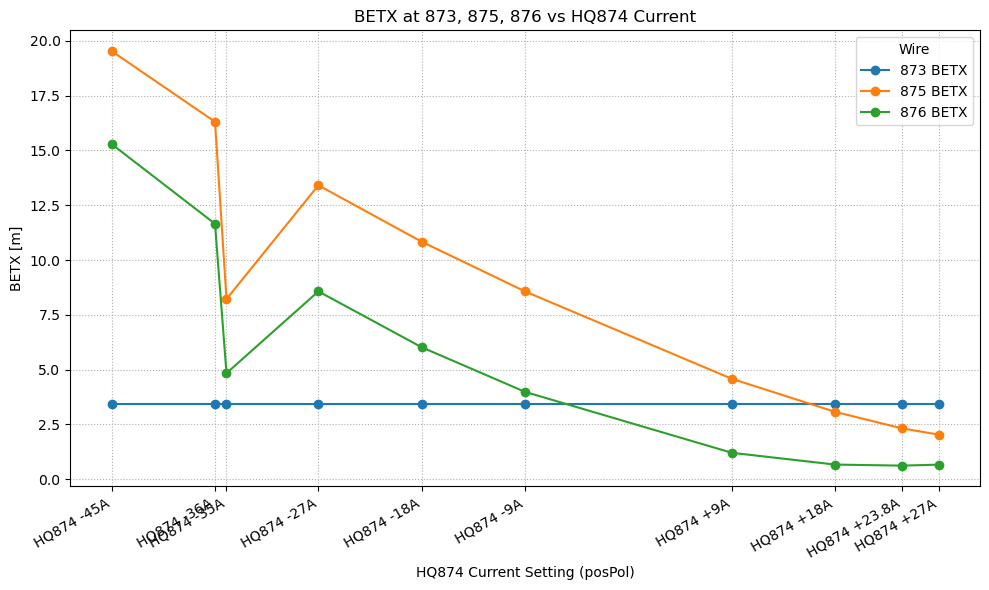

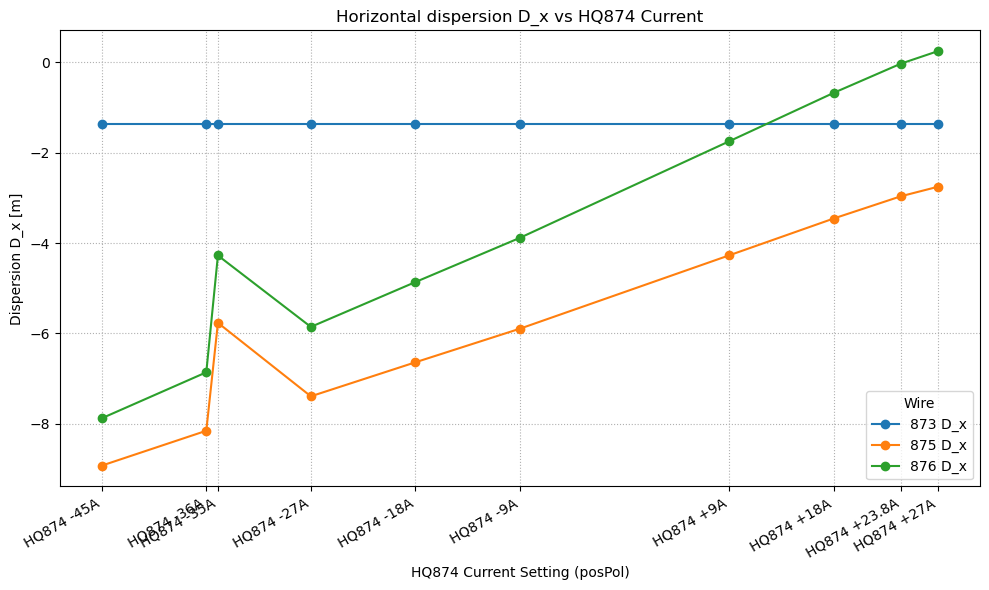

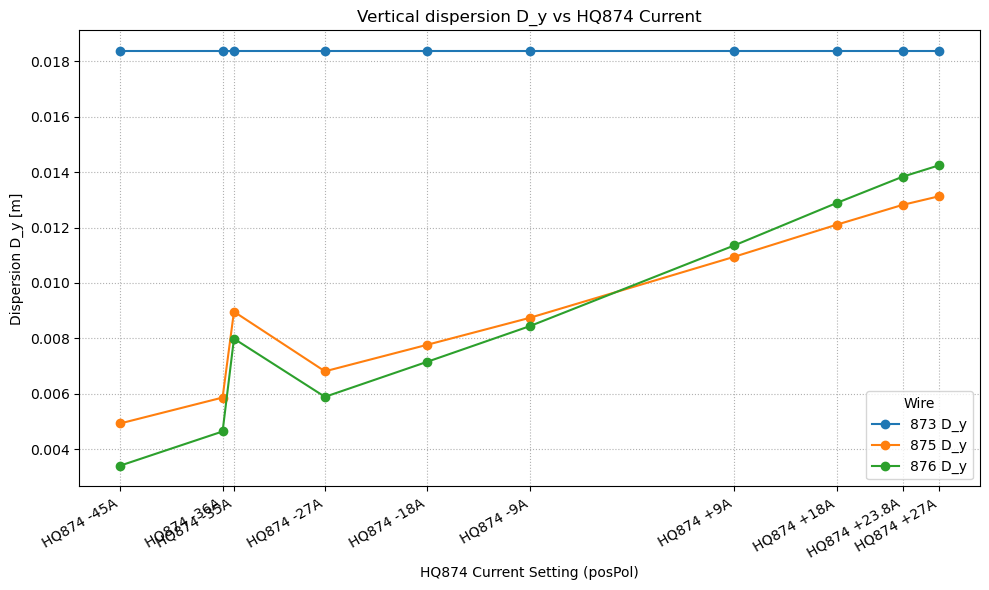

Wrote betax_vs_HQ874_current_posPol.csv and dispersion_vs_HQ874_current_posPol.csv


In [2]:
# -*- coding: utf-8 -*-
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# Config
# =============================================================================
MAGNET_FILE_TAG = "Q874"       # in filenames
MAGNET_LABEL    = "HQ874"      # for plot/CSV labels
SWEEP_POLARITY  = "posPol"     # << asked for these files
# We'll prefer a baseline with the same polarity, but fall back to flipPol if needed
BASELINE_POLARITY_PREFERENCE = ["posPol", "flipPol"]

# Wires + baseline measured σ (mm) used to fit eps, sigma_delta at 0 A
# (These are the same as Q873 script; replace if HQ874 has different σ.)
monitors = ["MW873","MW875","MW876"]
baseline_measured_mm = {
    ("MW873","H"): 2.30, ("MW873","V"): 5.00,
    ("MW875","H"): 5.00, ("MW875","V"): 1.37,
    ("MW876","H"): 3.77, ("MW876","V"): 0.969,
}

# =============================================================================
# File discovery
#   Sweep: twiss_Q874_baseline_±Xa_posPol.tfs
#   Baseline (0A): prefer ...baseline_posPol.tfs, else ...baseline_flipPol.tfs
#   Also tolerate a couple of legacy alternates.
# =============================================================================
def discover_sweep_files(polarity_tag):
    files = {}
    rx = re.compile(
        rf"^twiss_{MAGNET_FILE_TAG}_baseline_(?P<curr>[+-]?\d+(?:\.\d+)?)a_{polarity_tag}\.tfs$",
        re.IGNORECASE,
    )
    for nm in os.listdir("."):
        m = rx.match(nm)
        if m:
            key = m.group("curr")  # keep string (can be decimal)
            files[key] = nm
    if not files:
        raise RuntimeError(f"No {MAGNET_LABEL} sweep files found for polarity '{polarity_tag}'.")
    return files

def find_baseline_file():
    # 1) Prefer baseline with desired polarity, 2) else try other polarities in preference list, 3) legacy
    for pol in BASELINE_POLARITY_PREFERENCE:
        cand = f"twiss_{MAGNET_FILE_TAG}_baseline_{pol}.tfs"
        if os.path.exists(cand):
            return cand
    # Legacy zero-current variants that sometimes show up
    legacies = [
        f"twiss_{MAGNET_FILE_TAG}_default.tfs",
        f"twiss_{MAGNET_FILE_TAG}_0a_{SWEEP_POLARITY}.tfs",
        f"twiss_{MAGNET_FILE_TAG}_0A_{SWEEP_POLARITY}.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline.tfs",
    ]
    for nm in legacies:
        if os.path.exists(nm):
            return nm
    # As a last resort, if *only* a flipped baseline exists and wasn't caught above:
    flipped = f"twiss_{MAGNET_FILE_TAG}_baseline_flipPol.tfs"
    if os.path.exists(flipped):
        return flipped
    raise RuntimeError(
        f"Baseline (0 A) file not found for {MAGNET_LABEL}. "
        f"Expected one of: twiss_{MAGNET_FILE_TAG}_baseline_[posPol|flipPol].tfs"
    )

def key_to_float(k):
    try:
        return float(k)
    except:
        return float("inf")

def label_for_key(k: str) -> str:
    return f"{MAGNET_LABEL} {k}A" if k != "0" else f"{MAGNET_LABEL} Baseline"

# =============================================================================
# Robust TFS reader & helpers (same logic as Q873 script)
# =============================================================================
def read_tfs(path):
    if not path or not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    header_idx = None
    for i, ln in enumerate(lines):
        if ln.lstrip().startswith("*"):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError(f"No '*' header line in {path}")

    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1

    data_rows = []
    for ln in lines[start:]:
        if ln.strip() == "" or ln.lstrip().startswith(("@","#","*","$")):
            continue
        data_rows.append(ln)

    from io import StringIO
    df = pd.read_csv(
        StringIO("".join(data_rows)),
        sep=r"\s+", header=None, names=[c.upper() for c in cols], engine="python"
    )

    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            existing = df[df["NAME"].str.contains("MW", na=False)]["NAME"].unique()
            raise RuntimeError(f"{w} not found. MW-like names present: {existing[:10]}")
        out[w] = m.iloc[0]
    return out

def fit_plane_params(baseline_rows, plane):
    beta_col = "BETX" if plane=="H" else "BETY"
    disp_col = "DX"   if plane=="H" else "DY"
    y, X = [], []
    for w in monitors:
        sig_mm = baseline_measured_mm[(w,plane)]
        sig2_m2 = (sig_mm*1e-3)**2
        beta = float(baseline_rows[w][beta_col])
        disp = float(baseline_rows[w][disp_col])
        y.append(sig2_m2)
        X.append([beta, disp*disp])
    y = np.array(y); X = np.array(X)
    p, *_ = np.linalg.lstsq(X, y, rcond=None)
    eps, sdel2 = float(p[0]), float(p[1])
    return max(eps,0.0), max(sdel2,0.0)

# =============================================================================
# Load baseline, fit, sweep POS polarity
# =============================================================================
sweep_files = discover_sweep_files(SWEEP_POLARITY)
baseline_path = find_baseline_file()

df0 = read_tfs(baseline_path)
rows0 = get_mw_rows(df0)
eps_x, sdel2_x = fit_plane_params(rows0, "H")
eps_y, sdel2_y = fit_plane_params(rows0, "V")

print(f"Fitted params from 0A baseline ({os.path.basename(baseline_path)}):")
print(f"  H: eps = {eps_x:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_x):.3e}")
print(f"  V: eps = {eps_y:.3e} m·rad, sigma_delta = {math.sqrt(sdel2_y):.3e} (expect ~0)")

sigma_pred = { (w,"H"):[] for w in monitors }
sigma_pred.update({ (w,"V"):[] for w in monitors })
betx = { w:[] for w in monitors }
dx   = { w:[] for w in monitors }
dy   = { w:[] for w in monitors }

# Sort sweep keys numerically
ordered_keys = sorted(sweep_files.keys(), key=key_to_float)

files_used = []
labels_available = []

for key in ordered_keys:
    path = sweep_files[key]
    df = read_tfs(path)
    rows = get_mw_rows(df)
    labels_available.append(key)
    files_used.append((key, path))

    for w in monitors:
        bx  = float(rows[w]["BETX"]); ddx = float(rows[w]["DX"])
        by  = float(rows[w]["BETY"]); ddy = float(rows[w]["DY"])

        sig_h_mm = math.sqrt(eps_x*bx + sdel2_x*(ddx**2)) * 1e3
        sig_v_mm = math.sqrt(eps_y*by + sdel2_y*(ddy**2)) * 1e3

        sigma_pred[(w,"H")].append(sig_h_mm)
        sigma_pred[(w,"V")].append(sig_v_mm)

        betx[w].append(bx)
        dx[w].append(ddx)
        dy[w].append(ddy)

print("\nFiles used (sweep):")
for k, p in files_used:
    print(f"  {label_for_key(k)} -> {p}")
print(f"Baseline file: {baseline_path}")

# X axis arrays
xs = np.array([float(k) for k in labels_available])
xtick_labels = [label_for_key(k) for k in labels_available]

# =============================================================================
# σ vs current (prediction)
# =============================================================================
plt.figure(figsize=(10,6))
plot_order = [("MW873","H"),("MW873","V"),
              ("MW875","H"),("MW875","V"),
              ("MW876","H"),("MW876","V")]
plot_order = [kp for kp in plot_order if kp[0] in monitors]

for key in plot_order:
    y = sigma_pred[key]
    label = f"{key[0][-3:]} {key[1]}"
    plt.plot(xs, y, marker="o", label=label)

plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.ylabel("σ [mm]")
plt.title(f"Beam-spot σ vs {MAGNET_LABEL} Current (predicted from β, D @ 0A fit)")
plt.grid(True, linestyle=":")
plt.legend(title="Wire & Plane", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Save CSV
pred_cols = {f"{w} {p}": sigma_pred[(w,p)] for w in monitors for p in ("H","V")}
pred_df = pd.DataFrame(pred_cols, index=xtick_labels)
pred_df.to_csv(f"madx_pred_sigma_vs_current_{MAGNET_LABEL}_{SWEEP_POLARITY}.csv")
print(f"\nWrote madx_pred_sigma_vs_current_{MAGNET_LABEL}_{SWEEP_POLARITY}.csv")

# =============================================================================
# BETX vs current
# =============================================================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, betx[w], marker="o", label=f"{w[-3:]} BETX")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.ylabel("BETX [m]")
plt.title(f"BETX at {', '.join(m[-3:] for m in monitors)} vs {MAGNET_LABEL} Current")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# =============================================================================
# Dispersion Dx / Dy vs current
# =============================================================================
plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dx[w], marker="o", label=f"{w[-3:]} D_x")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.ylabel("Dispersion D_x [m]")
plt.title(f"Horizontal dispersion D_x vs {MAGNET_LABEL} Current")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
for w in monitors:
    plt.plot(xs, dy[w], marker="o", label=f"{w[-3:]} D_y")
plt.xticks(xs, xtick_labels, rotation=30, ha="right")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.ylabel("Dispersion D_y [m]")
plt.title(f"Vertical dispersion D_y vs {MAGNET_LABEL} Current")
plt.grid(True, linestyle=":")
plt.legend(title="Wire")
plt.tight_layout()
plt.show()

# Save optics/dispersion CSVs
pd.DataFrame({w: betx[w] for w in monitors}, index=xtick_labels)\
  .to_csv(f"betax_vs_{MAGNET_LABEL}_current_{SWEEP_POLARITY}.csv")
pd.DataFrame({**{f"{w} D_x": dx[w] for w in monitors},
               **{f"{w} D_y": dy[w] for w in monitors}},
             index=xtick_labels)\
  .to_csv(f"dispersion_vs_{MAGNET_LABEL}_current_{SWEEP_POLARITY}.csv")
print(f"Wrote betax_vs_{MAGNET_LABEL}_current_{SWEEP_POLARITY}.csv and dispersion_vs_{MAGNET_LABEL}_current_{SWEEP_POLARITY}.csv")


Skip -35 A: no measurement row provided
Skip +27 A: no measurement row provided
Wrote emittance_vs_Q874_current_posPol.csv


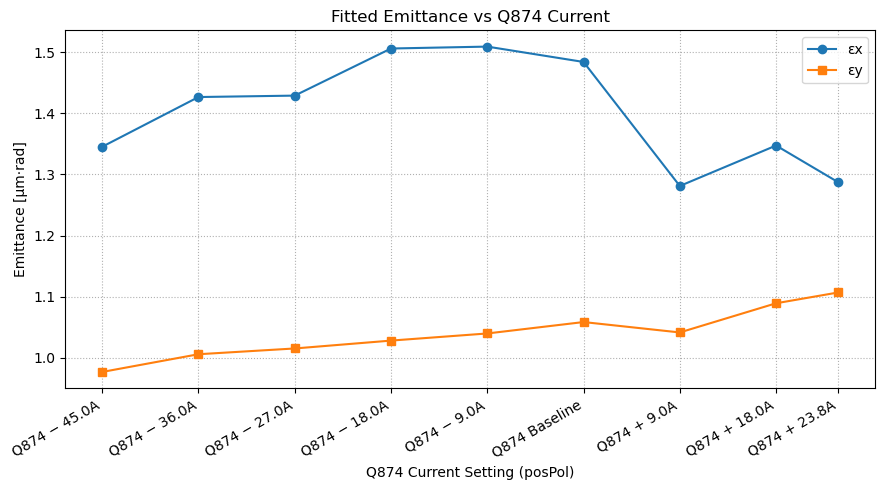

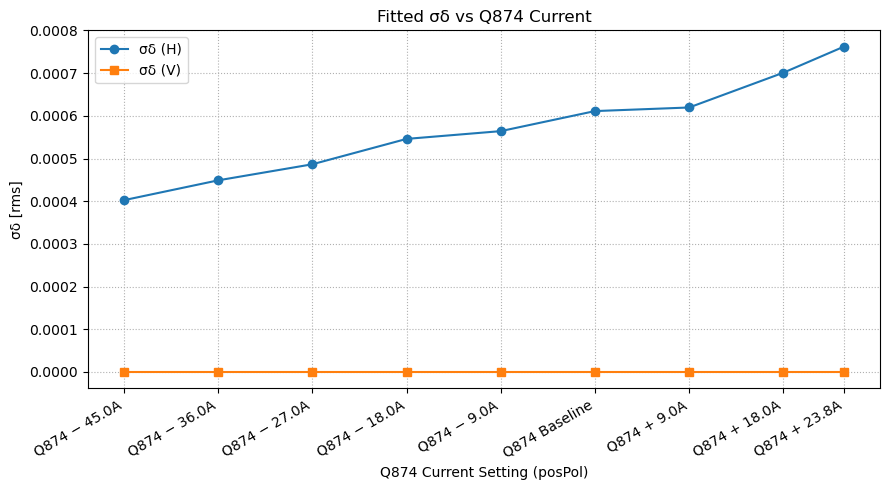

In [3]:
# -*- coding: utf-8 -*-
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Config / constants
# =========================
MAGNET_FILE_TAG = "Q874"
MAGNET_LABEL    = "Q874"
SWEEP_POLARITY  = "posPol"

monitors = ["MW873","MW875","MW876"]

# =========================
# Q874 σ (mm) data
# Each list: [873 H, 873 V, 875 H, 875 V, 876 H, 876 V]
# =========================
q874_data = {
    "Q874 − 45A":    [2.18,  4.94,  5.90, 0.494, 6.02, 0.655],
    "Q874 − 36A":    [2.23,  4.99,  5.62, 0.611, 5.77, 0.548],
    "Q874 − 27A":    [2.22,  5.00,  5.24, 0.785, 5.27, 0.508],
    "Q874 − 18A":    [2.25,  5.00,  4.96, 0.965, 5.02, 0.573],
    "Q874 − 9A":     [2.27,  5.01,  4.60, 1.17,  4.17, 0.739],
    "Q874 Baseline": [2.25,  4.99,  4.11, 1.37,  3.44, 0.963],
    "Q874 + 9A":     [2.15,  4.93,  3.52, 1.57,  2.42, 1.18],
    "Q874 + 18A":    [2.27,  4.99,  3.16, 1.80,  1.75, 1.45],
    "Q874 + 23.8A":  [2.30,  5.00,  2.85, 1.94,  1.30, 1.61],
}

meas_df = pd.DataFrame.from_dict(
    q874_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

# Build a robust index: map numeric current (float; 0.0 = baseline) -> measurement row
def build_meas_index(df):
    idx = {}
    rx = re.compile(r"q874\s*(baseline|([+\-−]\s*\d+(?:\.\d+)?)\s*a)", re.IGNORECASE)
    for name in df.index:
        m = rx.search(name.replace("\u00A0"," ").replace("\u2009"," "))
        if not m:
            continue
        if m.group(1).lower().startswith("baseline"):
            key = 0.0
        else:
            s = m.group(2).replace("−","-").replace(" ","")  # normalize unicode minus
            key = float(s)
        idx[key] = df.loc[name]
    return idx

meas_by_current = build_meas_index(meas_df)

# =========================
# File discovery (posPol sweep + optional baseline)
# =========================
def discover_sweep_files(polarity_tag):
    files = {}
    rx = re.compile(
        rf"^twiss_{MAGNET_FILE_TAG}_baseline_(?P<curr>[+\-]?\d+(?:\.\d+)?)a_{polarity_tag}\.tfs$",
        re.IGNORECASE
    )
    for nm in os.listdir("."):
        m = rx.match(nm)
        if m:
            files[float(m.group("curr"))] = nm
    if not files:
        raise RuntimeError(f"No {MAGNET_LABEL} sweep files found for polarity '{polarity_tag}'.")
    return files

def find_baseline_file():
    candidates = [
        f"twiss_{MAGNET_FILE_TAG}_baseline_{SWEEP_POLARITY}.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline_flipPol.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline.tfs",
        f"twiss_{MAGNET_FILE_TAG}_default.tfs",
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None  # baseline is optional; we skip if not found

sweep_files = discover_sweep_files(SWEEP_POLARITY)
baseline_path = find_baseline_file()
if baseline_path is not None:
    sweep_files[0.0] = baseline_path  # add baseline if available

# =========================
# TFS reader & helpers
# =========================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:]
                 if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=[c.upper() for c in cols], engine="python")
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            raise RuntimeError(f"{w} not found in TFS")
        out[w] = m.iloc[0]
    return out

def fit_eps_sdel2(sig_mm_list, beta_list, disp_list):
    y = np.array([(s*1e-3)**2 for s in sig_mm_list])          # m^2
    X = np.column_stack([np.array(beta_list), np.array(disp_list)**2])
    (eps, sdel2), *_ = np.linalg.lstsq(X, y, rcond=None)      # [ε, σδ^2]
    return max(float(eps),0.0), max(float(sdel2),0.0)

def label_for_current(I):
    if I == 0.0:
        return f"{MAGNET_LABEL} Baseline"
    sign = "+" if I > 0 else "−"  # U+2212 for minus
    return f"{MAGNET_LABEL} {sign} {abs(I)}A"

# =========================
# Loop currents, fit H & V
# =========================
results = []
epsx_list, epsy_list, sdx_list, sdy_list = [], [], [], []
xs, xtick_labels = [], []

for I in sorted(sweep_files.keys()):
    # must have measurements for this current; skip if not provided
    if I not in meas_by_current:
        print(f"Skip {I:+g} A: no measurement row provided")
        continue

    path = sweep_files[I]
    df = read_tfs(path)
    rows = get_mw_rows(df)
    meas = meas_by_current[I]

    # Assemble per-wire vectors
    betx = [float(rows[w]["BETX"]) for w in monitors]
    bety = [float(rows[w]["BETY"]) for w in monitors]
    dx   = [float(rows[w]["DX"])   for w in monitors]
    dy   = [float(rows[w]["DY"])   for w in monitors]

    sigx_mm = [float(meas["873 H"]), float(meas["875 H"]), float(meas["876 H"])]
    sigy_mm = [float(meas["873 V"]), float(meas["875 V"]), float(meas["876 V"])]

    # Fits
    epsx, sdel2x = fit_eps_sdel2(sigx_mm, betx, dx)
    epsy, sdel2y = fit_eps_sdel2(sigy_mm, bety, dy)

    epsx_list.append(epsx)
    epsy_list.append(epsy)
    sdx_list.append(math.sqrt(sdel2x))
    sdy_list.append(math.sqrt(sdel2y))
    xs.append(I)
    xtick_labels.append(label_for_current(I))

    results.append({
        "Current [A]": I,
        "Label": label_for_current(I),
        "eps_x [m rad]": epsx,
        "eps_y [m rad]": epsy,
        "sigma_delta_x": math.sqrt(sdel2x),
        "sigma_delta_y": math.sqrt(sdel2y),
        "TFS file": os.path.basename(path),
    })

# =========================
# Save table
# =========================
res_df = pd.DataFrame(results).set_index("Label")
res_df.to_csv("emittance_vs_Q874_current_posPol.csv")
print("Wrote emittance_vs_Q874_current_posPol.csv")

# =========================
# Plots: Emittance vs current
# =========================
xs_np = np.array(xs, dtype=float)

plt.figure(figsize=(9,5))
plt.plot(xs_np, np.array(epsx_list)*1e6, marker="o", label="εx")
plt.plot(xs_np, np.array(epsy_list)*1e6, marker="s", label="εy")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [µm·rad]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"Fitted Emittance vs {MAGNET_LABEL} Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# (Optional) Also plot fitted sigma_delta per plane
plt.figure(figsize=(9,5))
plt.plot(xs_np, sdx_list, marker="o", label="σδ (H)")
plt.plot(xs_np, sdy_list, marker="s", label="σδ (V)")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("σδ [rms]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"Fitted σδ vs {MAGNET_LABEL} Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()


Skip -35 A: no measurement row provided
Skip +27 A: no measurement row provided
Wrote momentum_spread_vs_Q874_current_with_Dp.csv


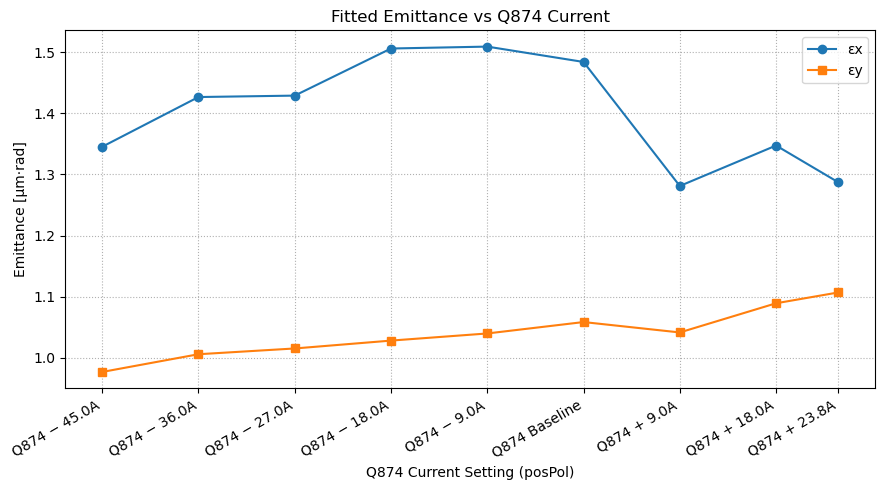

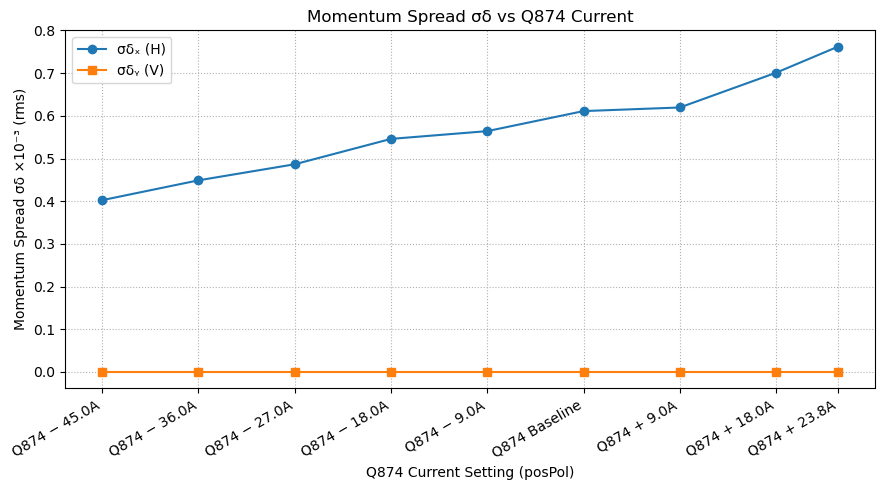

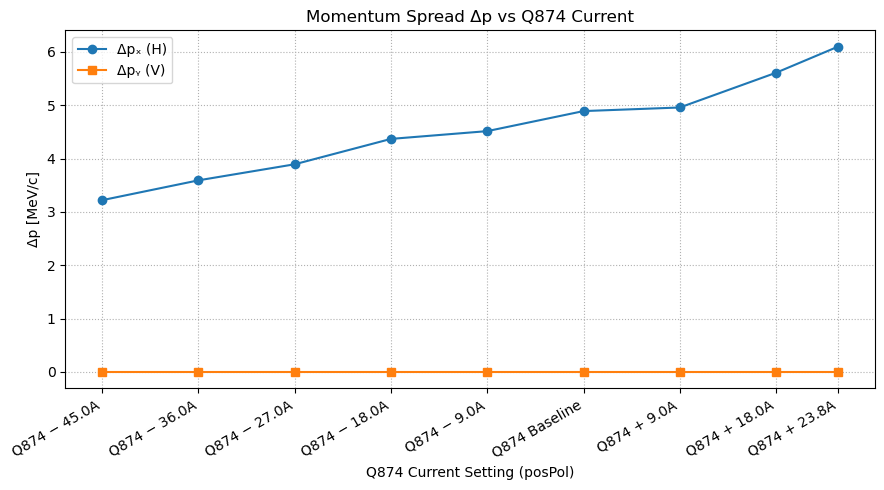

In [2]:
# -*- coding: utf-8 -*-
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====================================================
# CONFIGURATION
# ====================================================
MAGNET_FILE_TAG = "Q874"
MAGNET_LABEL    = "Q874"
SWEEP_POLARITY  = "posPol"

monitors = ["MW873", "MW875", "MW876"]
P0_MEV = 8000.0  # Reference momentum in MeV/c

# ====================================================
# INPUT DATA (σ in mm)
# ====================================================
q874_data = {
    "Q874 − 45A":    [2.18,  4.94,  5.90, 0.494, 6.02, 0.655],
    "Q874 − 36A":    [2.23,  4.99,  5.62, 0.611, 5.77, 0.548],
    "Q874 − 27A":    [2.22,  5.00,  5.24, 0.785, 5.27, 0.508],
    "Q874 − 18A":    [2.25,  5.00,  4.96, 0.965, 5.02, 0.573],
    "Q874 − 9A":     [2.27,  5.01,  4.60, 1.17,  4.17, 0.739],
    "Q874 Baseline": [2.25,  4.99,  4.11, 1.37,  3.44, 0.963],
    "Q874 + 9A":     [2.15,  4.93,  3.52, 1.57,  2.42, 1.18],
    "Q874 + 18A":    [2.27,  4.99,  3.16, 1.80,  1.75, 1.45],
    "Q874 + 23.8A":  [2.30,  5.00,  2.85, 1.94,  1.30, 1.61],
}

meas_df = pd.DataFrame.from_dict(
    q874_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

# ====================================================
# BUILD INDEX AND FIND FILES
# ====================================================
def build_meas_index(df):
    idx = {}
    rx = re.compile(r"q874\s*(baseline|([+\-−]\s*\d+(?:\.\d+)?)\s*a)", re.IGNORECASE)
    for name in df.index:
        m = rx.search(name.replace("\u00A0"," ").replace("\u2009"," "))
        if not m:
            continue
        if m.group(1).lower().startswith("baseline"):
            key = 0.0
        else:
            s = m.group(2).replace("−", "-").replace(" ", "")
            key = float(s)
        idx[key] = df.loc[name]
    return idx

meas_by_current = build_meas_index(meas_df)

def discover_sweep_files(polarity_tag):
    files = {}
    rx = re.compile(
        rf"^twiss_{MAGNET_FILE_TAG}_baseline_(?P<curr>[+\-]?\d+(?:\.\d+)?)a_{polarity_tag}\.tfs$",
        re.IGNORECASE
    )
    for nm in os.listdir("."):
        m = rx.match(nm)
        if m:
            files[float(m.group("curr"))] = nm
    if not files:
        raise RuntimeError(f"No {MAGNET_LABEL} sweep files found for polarity '{polarity_tag}'.")
    return files

def find_baseline_file():
    candidates = [
        f"twiss_{MAGNET_FILE_TAG}_baseline_{SWEEP_POLARITY}.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline_flipPol.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline.tfs",
        f"twiss_{MAGNET_FILE_TAG}_default.tfs",
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None

sweep_files = discover_sweep_files(SWEEP_POLARITY)
baseline_path = find_baseline_file()
if baseline_path is not None:
    sweep_files[0.0] = baseline_path

# ====================================================
# TFS READER AND FIT FUNCTIONS
# ====================================================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:] if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)), sep=r"\s+", header=None, names=[c.upper() for c in cols])
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper().str.strip()
                      .str.strip('"').str.strip("'").str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            raise RuntimeError(f"{w} not found in TFS")
        out[w] = m.iloc[0]
    return out

def fit_eps_sdel2(sig_mm_list, beta_list, disp_list):
    y = np.array([(s*1e-3)**2 for s in sig_mm_list])  # m^2
    X = np.column_stack([np.array(beta_list), np.array(disp_list)**2])
    (eps, sdel2), *_ = np.linalg.lstsq(X, y, rcond=None)
    return max(float(eps),0.0), max(float(sdel2),0.0)

def label_for_current(I):
    if I == 0.0:
        return f"{MAGNET_LABEL} Baseline"
    sign = "+" if I > 0 else "−"
    return f"{MAGNET_LABEL} {sign} {abs(I)}A"

# ====================================================
# MAIN FIT LOOP
# ====================================================
results = []
epsx_list, epsy_list, sdx_list, sdy_list = [], [], [], []
xs, xtick_labels = [], []

for I in sorted(sweep_files.keys()):
    if I not in meas_by_current:
        print(f"Skip {I:+g} A: no measurement row provided")
        continue

    path = sweep_files[I]
    df = read_tfs(path)
    rows = get_mw_rows(df)
    meas = meas_by_current[I]

    betx = [float(rows[w]["BETX"]) for w in monitors]
    bety = [float(rows[w]["BETY"]) for w in monitors]
    dx   = [float(rows[w]["DX"])   for w in monitors]
    dy   = [float(rows[w]["DY"])   for w in monitors]

    sigx_mm = [float(meas["873 H"]), float(meas["875 H"]), float(meas["876 H"])]
    sigy_mm = [float(meas["873 V"]), float(meas["875 V"]), float(meas["876 V"])]

    epsx, sdel2x = fit_eps_sdel2(sigx_mm, betx, dx)
    epsy, sdel2y = fit_eps_sdel2(sigy_mm, bety, dy)

    epsx_list.append(epsx)
    epsy_list.append(epsy)
    sdx_list.append(math.sqrt(sdel2x))
    sdy_list.append(math.sqrt(sdel2y))
    xs.append(I)
    xtick_labels.append(label_for_current(I))

    results.append({
        "Current [A]": I,
        "Label": label_for_current(I),
        "eps_x [m rad]": epsx,
        "eps_y [m rad]": epsy,
        "sigma_delta_x": math.sqrt(sdel2x),
        "sigma_delta_y": math.sqrt(sdel2y),
        "Δp_x [MeV/c]": math.sqrt(sdel2x) * P0_MEV,  # momentum spread
        "Δp_y [MeV/c]": math.sqrt(sdel2y) * P0_MEV,
        "TFS file": os.path.basename(path),
    })

# ====================================================
# SAVE OUTPUT TABLES
# ====================================================
res_df = pd.DataFrame(results).set_index("Label")
res_df.to_csv("momentum_spread_vs_Q874_current_with_Dp.csv")
print("Wrote momentum_spread_vs_Q874_current_with_Dp.csv")

# ====================================================
# PLOTS
# ====================================================
xs_np = np.array(xs, dtype=float)

# --- Emittance ---
plt.figure(figsize=(9,5))
plt.plot(xs_np, np.array(epsx_list)*1e6, marker="o", label="εx")
plt.plot(xs_np, np.array(epsy_list)*1e6, marker="s", label="εy")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [µm·rad]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"Fitted Emittance vs {MAGNET_LABEL} Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# --- σδ ---
plt.figure(figsize=(9,5))
plt.plot(xs_np, np.array(sdx_list)*1e3, marker="o", label="σδₓ (H)")
plt.plot(xs_np, np.array(sdy_list)*1e3, marker="s", label="σδᵧ (V)")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Momentum Spread σδ ×10⁻³ (rms)")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"Momentum Spread σδ vs {MAGNET_LABEL} Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# --- Δp ---
plt.figure(figsize=(9,5))
plt.plot(xs_np, np.array(sdx_list)*P0_MEV, marker="o", label="Δpₓ (H)")
plt.plot(xs_np, np.array(sdy_list)*P0_MEV, marker="s", label="Δpᵧ (V)")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Δp [MeV/c]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"Momentum Spread Δp vs {MAGNET_LABEL} Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()



Skip -35 A: no measurement row provided
Skip +27 A: no measurement row provided
Wrote emittance_vs_Q874_current_posPol_with_errors.csv


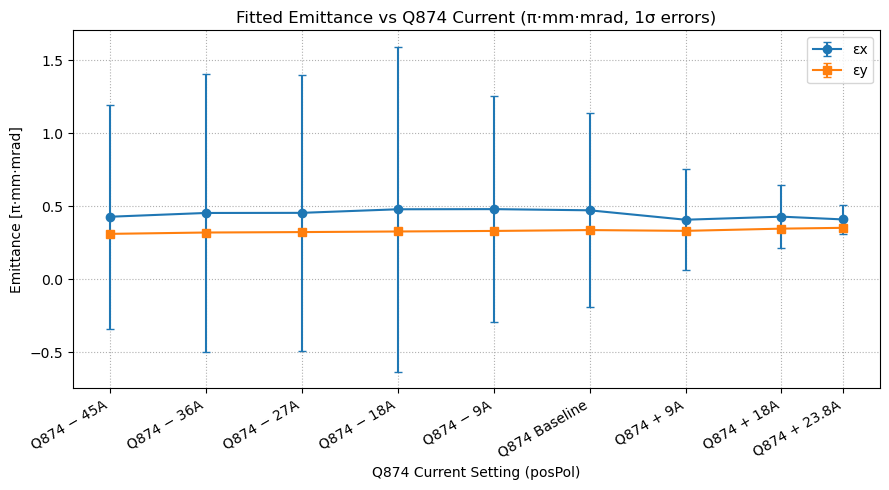

Wrote emittance_vs_Q874_current_posPol_pi-mm-mrad.csv


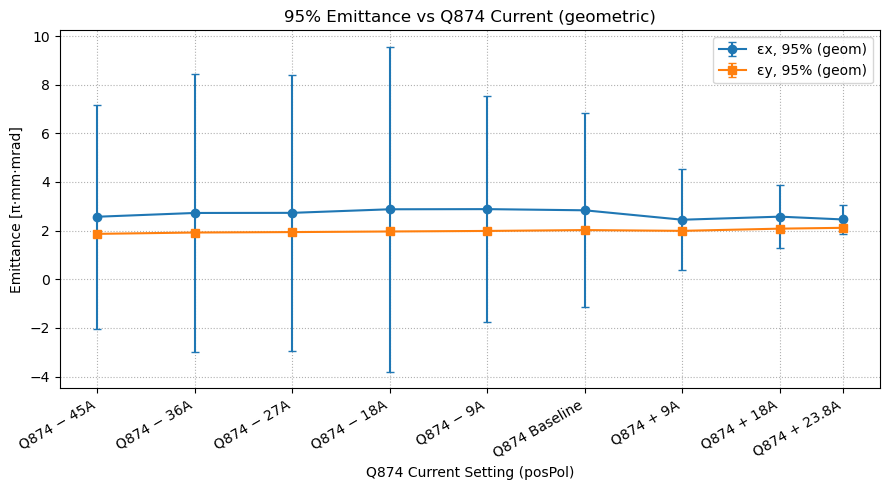

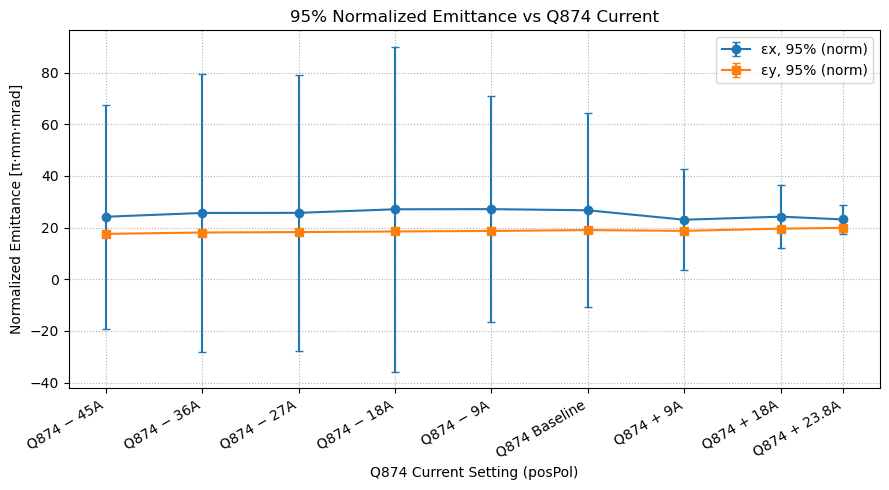

Wrote 95% geometric and normalized CSVs.


In [4]:

 # -*- coding: utf-8 -*-
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Config / constants
# =========================
MAGNET_FILE_TAG = "Q874"
MAGNET_LABEL    = "Q874"
SWEEP_POLARITY  = "posPol"

monitors = ["MW873","MW875","MW876"]

# =========================================
# SET MONITOR RESOLUTION HERE (mm)
# (subtracted in quadrature: sigma_corr^2 = sigma_meas^2 - sigma_res^2)
# Give a single number or a dict per wire if needed.
# =========================================
RES_H_MM = 0.00   # horizontal resolution (mm) or dict per wire
RES_V_MM = 0.00   # vertical   resolution (mm) or dict per wire
# Example per-wire override:
# RES_H_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}
# RES_V_MM = {"MW873":0.00, "MW875":0.00, "MW876":0.00}

def get_res_mm(plane, wire):
    val = RES_H_MM if plane=="H" else RES_V_MM
    if isinstance(val, dict):
        return float(val.get(wire, 0.0))
    return float(val)

# =========================
# Q874 σ (mm) data
# Each list: [873 H, 873 V, 875 H, 875 V, 876 H, 876 V]
# =========================
q874_data = {
    "Q874 − 45A":    [2.18,  4.94,  5.90, 0.494, 6.02, 0.655],
    "Q874 − 36A":    [2.23,  4.99,  5.62, 0.611, 5.77, 0.548],
    "Q874 − 27A":    [2.22,  5.00,  5.24, 0.785, 5.27, 0.508],
    "Q874 − 18A":    [2.25,  5.00,  4.96, 0.965, 5.02, 0.573],
    "Q874 − 9A":     [2.27,  5.01,  4.60, 1.17,  4.17, 0.739],
    "Q874 Baseline": [2.25,  4.99,  4.11, 1.37,  3.44, 0.963],
    "Q874 + 9A":     [2.15,  4.93,  3.52, 1.57,  2.42, 1.18],
    "Q874 + 18A":    [2.27,  4.99,  3.16, 1.80,  1.75, 1.45],
    "Q874 + 23.8A":  [2.30,  5.00,  2.85, 1.94,  1.30, 1.61],
}
meas_df = pd.DataFrame.from_dict(
    q874_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

# Build a robust index: map numeric current (float; 0.0 = baseline) -> measurement row
def build_meas_index(df):
    idx = {}
    rx = re.compile(r"q874\s*(baseline|([+\-−]?\s*\d+(?:\.\d+)?)\s*a)", re.IGNORECASE)
    for name in df.index:
        norm = name.replace("\u00A0"," ").replace("\u2009"," ")
        m = rx.search(norm)
        if not m:
            continue
        if m.group(1).lower().startswith("baseline"):
            key = 0.0
        else:
            s = m.group(2).replace("−","-").replace(" ","")
            key = float(s)
        idx[key] = df.loc[name]
    return idx

meas_by_current = build_meas_index(meas_df)

# =========================
# File discovery (posPol sweep + optional baseline)
# =========================
def discover_sweep_files(polarity_tag):
    files = {}
    rx = re.compile(
        rf"^twiss_{MAGNET_FILE_TAG}_baseline_(?P<curr>[+\-]?\d+(?:\.\d+)?)a_{polarity_tag}\.tfs$",
        re.IGNORECASE
    )
    for nm in os.listdir("."):
        m = rx.match(nm)
        if m:
            curr = float(m.group("curr"))
            files[curr] = nm
    if not files:
        raise RuntimeError(f"No {MAGNET_LABEL} sweep files found for polarity '{polarity_tag}'.")
    return files

def find_baseline_file():
    # If we also have a single baseline file without current, add it here
    candidates = [
        f"twiss_{MAGNET_FILE_TAG}_baseline_{SWEEP_POLARITY}.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline_flipPol.tfs",
        f"twiss_{MAGNET_FILE_TAG}_baseline.tfs",
        f"twiss_{MAGNET_FILE_TAG}_default.tfs",
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    return None

sweep_files = discover_sweep_files(SWEEP_POLARITY)
baseline_path = find_baseline_file()
if baseline_path is not None:
    sweep_files[0.0] = baseline_path  # add baseline if available

# =========================
# TFS reader & helpers
# =========================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    header_idx = next(i for i,l in enumerate(lines) if l.lstrip().startswith("*"))
    cols = re.sub(r"^\*", "", lines[header_idx]).strip().split()
    start = header_idx + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    data_rows = [ln for ln in lines[start:]
                 if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)),
                     sep=r"\s+", header=None, names=[c.upper() for c in cols], engine="python")
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_mw_rows(df):
    out = {}
    for w in monitors:
        m = df[df["NAME"] == w]
        if m.empty:
            m = df[df["NAME"].str.contains(w, na=False)]
        if m.empty:
            raise RuntimeError(f"{w} not found in TFS")
        out[w] = m.iloc[0]
    return out

# ====== Fitting utilities with uncertainties ======
def subtract_resolution_mm(sig_mm, res_mm):
    s2 = sig_mm**2 - res_mm**2
    return math.sqrt(s2) if s2 > 0 else 0.0

def fit_two_param(sig_mm_list, beta_list, disp_list):
    # y = σ^2(m^2) = ε*β + σδ^2 * D^2
    y = np.array([(s*1e-3)**2 for s in sig_mm_list], float)
    X = np.column_stack([np.array(beta_list, float),
                         np.array(disp_list, float)**2])
    p, *_ = np.linalg.lstsq(X, y, rcond=None)
    eps, sdel2 = float(p[0]), float(p[1])

    r = y - X @ p
    N, P = X.shape
    dof = max(N - P, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    try:
        cov = s2 * np.linalg.inv(X.T @ X)
        std = np.sqrt(np.diag(cov))
        eps_std, sdel2_std = float(std[0]), float(std[1])
    except np.linalg.LinAlgError:
        eps_std, sdel2_std = float("nan"), float("nan")

    return max(eps,0.0), max(sdel2,0.0), eps_std, sdel2_std

def fit_one_param(sig_mm_list, beta_list):
    # y = ε*β; Var(ε) = s2 / (Σ β^2)
    y = np.array([(s*1e-3)**2 for s in sig_mm_list], float)
    X = np.array(beta_list, float).reshape(-1,1)
    denom = float((X.T @ X)[0,0])
    eps = float((X.T @ y)[0]) / denom if denom > 0 else 0.0
    r = y - X.flatten()*eps
    dof = max(len(y) - 1, 1)
    rss = float(r.T @ r)
    s2 = rss / dof
    eps_std = math.sqrt(s2/denom) if denom > 0 else float("nan")
    return max(eps,0.0), eps_std

COND_THRESH = 1e10
DY_THRESH   = 1e-3  # [m]

def label_for_current(I):
    if I == 0.0:
        return f"{MAGNET_LABEL} Baseline"
    sign = "+" if I > 0 else "−"  # U+2212
    # avoid trailing .0 for integers
    val = int(abs(I)) if abs(I).is_integer() else abs(I)
    return f"{MAGNET_LABEL} {sign} {val}A"

# =========================
# Loop currents, subtract resolution, fit H & V
# =========================
results = []
xs, xtick_labels = [], []
epsx, epsx_std, epsy, epsy_std = [], [], [], []
sdx, sdx_std, sdy, sdy_std     = [], [], [], []

for I in sorted(sweep_files.keys()):
    if I not in meas_by_current:
        print(f"Skip {I:+g} A: no measurement row provided")
        continue

    path = sweep_files[I]
    df = read_tfs(path)
    rows = get_mw_rows(df)
    meas = meas_by_current[I]

    # Assemble per-wire optics
    betx = [float(rows[w]["BETX"]) for w in monitors]
    bety = [float(rows[w]["BETY"]) for w in monitors]
    dx   = [float(rows[w]["DX"])   for w in monitors]
    dy   = [float(rows[w]["DY"])   for w in monitors]

    # Measured sigmas with resolution subtraction (per plane and wire)
    sigx_mm, sigy_mm = [], []
    for w, short in zip(monitors, ["873","875","876"]):
        sx = float(meas[f"{short} H"])
        sy = float(meas[f"{short} V"])
        sigx_mm.append(subtract_resolution_mm(sx, get_res_mm("H", w)))
        sigy_mm.append(subtract_resolution_mm(sy, get_res_mm("V", w)))

    # --- Horizontal: 2-parameter fit (β, D^2)
    ex, sdx2, ex_std, sdx2_std = fit_two_param(sigx_mm, betx, dx)
    sdx_val   = math.sqrt(sdx2)
    sdx_stdev = 0.5*sdx2_std/math.sqrt(sdx2) if sdx2 > 0 and np.isfinite(sdx2_std) else float("nan")

    # --- Vertical: try 2-param; fallback to 1-param if ill-conditioned or tiny DY
    use_one_param_v = (max(abs(v) for v in dy) < DY_THRESH)
    if not use_one_param_v:
        Xv = np.column_stack([np.array(bety, float), np.array(dy, float)**2])
        try:
            cond = np.linalg.cond(Xv)
            use_one_param_v = cond > COND_THRESH
        except np.linalg.LinAlgError:
            use_one_param_v = True

    if use_one_param_v:
        ey, ey_s = fit_one_param(sigy_mm, bety)
        sdy_val, sdy_s = 0.0, 0.0
        fit_mode_y = "1-param (Dy≈0/ill-cond)"
    else:
        ey, sdy2, ey_s, sdy2_s = fit_two_param(sigy_mm, bety, dy)
        sdy_val   = math.sqrt(sdy2)
        sdy_s     = 0.5*sdy2_s/math.sqrt(sdy2) if sdy2 > 0 and np.isfinite(sdy2_s) else float("nan")
        fit_mode_y = "2-param"

    xs.append(I)
    xtick_labels.append(label_for_current(I))
    epsx.append(ex); epsx_std.append(ex_std)
    epsy.append(ey); epsy_std.append(ey_s)
    sdx.append(sdx_val); sdx_std.append(sdx_stdev)
    sdy.append(sdy_val); sdy_std.append(sdy_s)

    results.append({
        "Current [A]": I,
        "Label": label_for_current(I),
        "eps_x [m rad]": ex,  "eps_x_std [m rad]": ex_std,
        "eps_y [m rad]": ey,  "eps_y_std [m rad]": ey_s,
        "sigma_delta_x": sdx_val, "sigma_delta_x_std": sdx_stdev,
        "sigma_delta_y": sdy_val, "sigma_delta_y_std": sdy_s,
        "fit_mode_y": fit_mode_y,
        "TFS file": os.path.basename(path),
    })

# =========================
# Save base CSV
# =========================
res_df = pd.DataFrame(results).set_index("Label")
out_base = f"emittance_vs_{MAGNET_FILE_TAG}_current_{SWEEP_POLARITY}_with_errors.csv"
res_df.to_csv(out_base)
print(f"Wrote {out_base}")

# =========================
# Plots with error bars (π·mm·mrad)
# =========================
xs_np = np.array(xs, dtype=float)
scale_pi_mm_mrad = 1e6 / math.pi  # m·rad -> π·mm·mrad

epsx_pi   = np.array(epsx)     * scale_pi_mm_mrad
epsy_pi   = np.array(epsy)     * scale_pi_mm_mrad
epsx_pi_e = np.array(epsx_std) * scale_pi_mm_mrad
epsy_pi_e = np.array(epsy_std) * scale_pi_mm_mrad

plt.figure(figsize=(9,5))
plt.errorbar(xs_np, epsx_pi, yerr=epsx_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx")
plt.errorbar(xs_np, epsy_pi, yerr=epsy_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [π·mm·mrad]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"Fitted Emittance vs {MAGNET_LABEL} Current (π·mm·mrad, 1σ errors)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

emi_out = pd.DataFrame({
    "eps_x [π·mm·mrad]": epsx_pi,
    "eps_x_std [π·mm·mrad]": epsx_pi_e,
    "eps_y [π·mm·mrad]": epsy_pi,
    "eps_y_std [π·mm·mrad]": epsy_pi_e,
}, index=xtick_labels)
out_pi = f"emittance_vs_{MAGNET_FILE_TAG}_current_{SWEEP_POLARITY}_pi-mm-mrad.csv"
emi_out.to_csv(out_pi)
print(f"Wrote {out_pi}")

# ---- 95% emittance from rms results ----
F95 = 6.0  # 95% ≈ 6 × rms (FNAL convention)
p_GeV = 8.83490
m_GeV = 0.9382720813
bg = p_GeV / m_GeV          # βγ ≈ 9.41 at 8.8349 GeV/c

epsx95_pi   = F95 * np.array(epsx)     * scale_pi_mm_mrad
epsy95_pi   = F95 * np.array(epsy)     * scale_pi_mm_mrad
epsx95_pi_e = F95 * np.array(epsx_std) * scale_pi_mm_mrad
epsy95_pi_e = F95 * np.array(epsy_std) * scale_pi_mm_mrad

epsx95n_pi   = epsx95_pi   * bg
epsy95n_pi   = epsy95_pi   * bg
epsx95n_pi_e = epsx95_pi_e * bg
epsy95n_pi_e = epsy95_pi_e * bg

# ---- Plot geometric 95% ----
plt.figure(figsize=(9,5))
plt.errorbar(xs_np, epsx95_pi, yerr=epsx95_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx, 95% (geom)")
plt.errorbar(xs_np, epsy95_pi, yerr=epsy95_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy, 95% (geom)")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Emittance [π·mm·mrad]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title(f"95% Emittance vs {MAGNET_LABEL} Current (geometric)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot normalized 95% ----
plt.figure(figsize=(9,5))
plt.errorbar(xs_np, epsx95n_pi, yerr=epsx95n_pi_e, marker="o", linestyle="-",
             capsize=3, label="εx, 95% (norm)")
plt.errorbar(xs_np, epsy95n_pi, yerr=epsy95n_pi_e, marker="s", linestyle="-",
             capsize=3, label="εy, 95% (norm)")
plt.xticks(xs_np, xtick_labels, rotation=30, ha="right")
plt.ylabel("Normalized Emittance [π·mm·mrad]")
plt.xlabel(f"{MAGNET_LABEL} Current Setting ({SWEEP_POLARITY})")
plt.title("95% Normalized Emittance vs Q874 Current")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Save 95% CSVs ----
pd.DataFrame({
    "epsx_95_geom [π·mm·mrad]": epsx95_pi,
    "epsx_95_geom_std [π·mm·mrad]": epsx95_pi_e,
    "epsy_95_geom [π·mm·mrad]": epsy95_pi,
    "epsy_95_geom_std [π·mm·mrad]": epsy95_pi_e,
}, index=xtick_labels).to_csv(f"emittance95_geometric_{MAGNET_FILE_TAG}_{SWEEP_POLARITY}_pi-mm-mrad.csv")

pd.DataFrame({
    "epsx_95_norm [π·mm·mrad]": epsx95n_pi,
    "epsx_95_norm_std [π·mm·mrad]": epsx95n_pi_e,
    "epsy_95_norm [π·mm·mrad]": epsy95n_pi,
    "epsy_95_norm_std [π·mm·mrad]": epsy95n_pi_e,
}, index=xtick_labels).to_csv(f"emittance95_normalized_{MAGNET_FILE_TAG}_{SWEEP_POLARITY}_pi-mm-mrad.csv")

print("Wrote 95% geometric and normalized CSVs.")


Ref current +0 A | fitted σδ = 7.978e-04
Skip Q874 + 27A: no measurement row provided
Skip Q874 − 35A: no measurement row provided
Wrote CSVs: Dx_estimates_vs_current_Q874_posPol.csv, Dy_estimates_vs_current_Q874_posPol.csv, target_sigma_prediction_scaled_D_Q874_posPol.csv


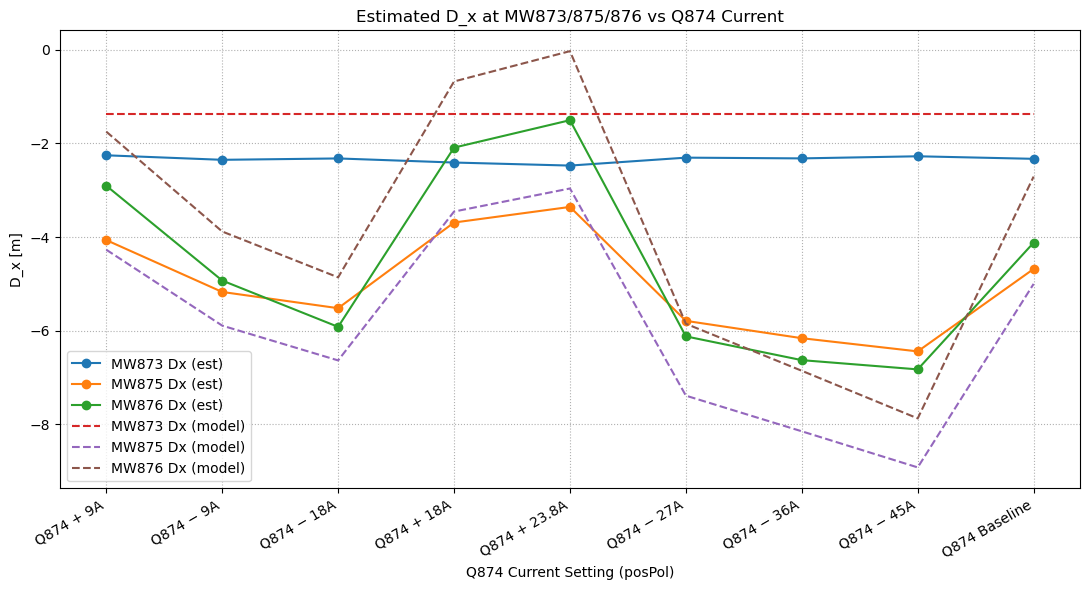

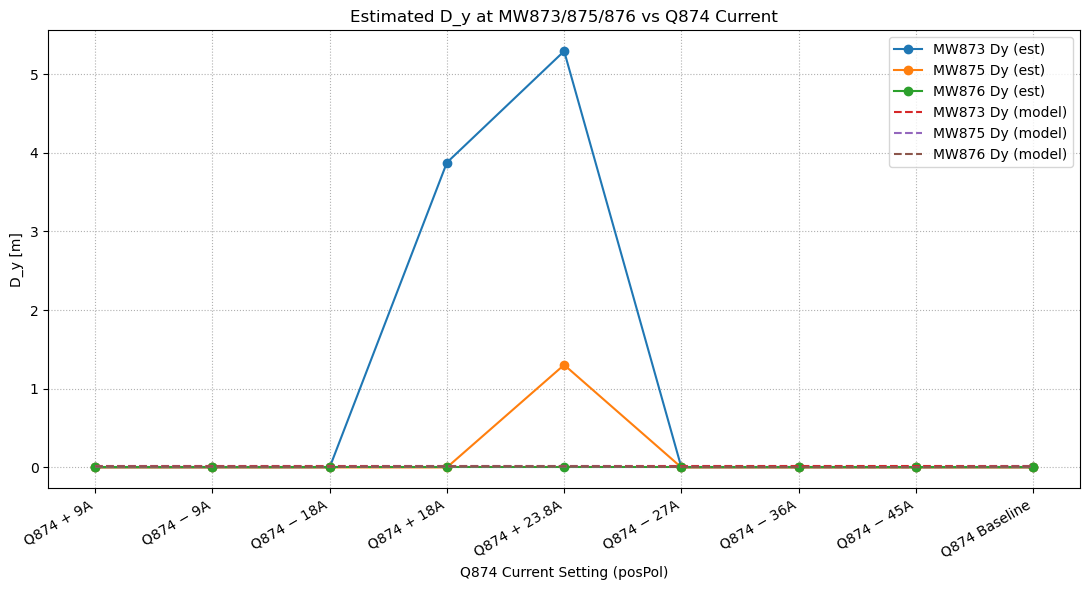

Wrote CSVs: Dx_estimates_vs_current.csv, Dy_estimates_vs_current.csv, target_sigma_prediction_scaled_D.csv


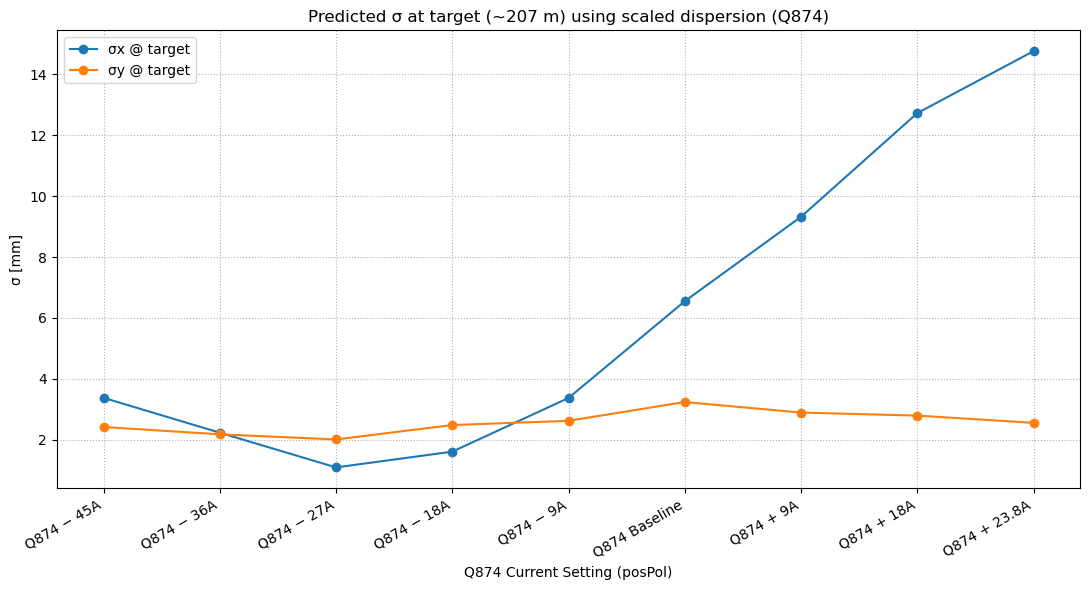

In [8]:
# -*- coding: utf-8 -*-
import os, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# 0) Where are the files?
# =========================================================
BASE = "."  # change if TFS/CSV live elsewhere
def P(path):  # join helper
    return path if os.path.isabs(path) else os.path.join(BASE, path)

# =========================================================
# 1) Q874 file discovery (posPol sweep) + labels
#    matches: twiss_Q874_baseline_+23.8a_posPol.tfs
# =========================================================
MAGNET = "Q874"
POLARITY = "posPol"
FILE_RX = re.compile(
    r"^twiss_Q874_baseline_(?P<I>[+\-]?\d+(?:\.\d+)?)a_" + re.escape(POLARITY) + r"\.tfs$",
    re.IGNORECASE
)

def discover_q874_files():
    out = {}
    for nm in os.listdir(P(".")):
        m = FILE_RX.match(nm)
        if m:
            I = float(m.group("I"))
            out[I] = P(nm)
    # optionally allow a true 0A baseline file if present
    for cand in [
        "twiss_Q874_baseline_%s.tfs" % POLARITY,
        "twiss_Q874_baseline_flipPol.tfs",
        "twiss_Q874_baseline.tfs",
        "twiss_Q874_default.tfs",
    ]:
        p = P(cand)
        if os.path.exists(p):
            out[0.0] = p
            break
    if not out:
        raise RuntimeError("No Q874 sweep files found for polarity '%s'." % POLARITY)
    return out

def label_for_I(I):
    if I == 0.0:
        return f"{MAGNET} Baseline"
    sign = "+" if I > 0 else "−"  # U+2212
    val = int(abs(I)) if abs(I).is_integer() else abs(I)
    return f"{MAGNET} {sign} {val}A"

sweep_files = discover_q874_files()
ordered_I = sorted(sweep_files.keys(), key=lambda x: (x==0.0, abs(x)))  # 0 first if present, then by |I|
xlabels = [label_for_I(I) for I in ordered_I]

monitors = ["MW873","MW875","MW876"]

# =========================================================
# 2) Q874 measured σ (mm) table
# =========================================================
q874_data = {
    "Q874 − 45A":    [2.18,  4.94,  5.90, 0.494, 6.02, 0.655],
    "Q874 − 36A":    [2.23,  4.99,  5.62, 0.611, 5.77, 0.548],
    "Q874 − 27A":    [2.22,  5.00,  5.24, 0.785, 5.27, 0.508],
    "Q874 − 18A":    [2.25,  5.00,  4.96, 0.965, 5.02, 0.573],
    "Q874 − 9A":     [2.27,  5.01,  4.60, 1.17,  4.17, 0.739],
    "Q874 Baseline": [2.25,  4.99,  4.11, 1.37,  3.44, 0.963],
    "Q874 + 9A":     [2.15,  4.93,  3.52, 1.57,  2.42, 1.18],
    "Q874 + 18A":    [2.27,  4.99,  3.16, 1.80,  1.75, 1.45],
    "Q874 + 23.8A":  [2.30,  5.00,  2.85, 1.94,  1.30, 1.61],
}
meas_df = pd.DataFrame.from_dict(
    q874_data, orient="index",
    columns=["873 H","873 V","875 H","875 V","876 H","876 V"]
)
meas_df.index.name = "Setup"

def find_meas_row(label):
    """Exact label match, tolerant to spaces & unicode minus."""
    target = label.replace(" ", "").replace("−","-")
    for idx in meas_df.index:
        if idx.replace(" ", "").replace("−","-") == target:
            return meas_df.loc[idx]
    raise KeyError(f"Measurement row not found for '{label}'")

# =========================================================
# 3) TFS reader + helpers
# =========================================================
def read_tfs(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    # header
    hdr = next((i for i,ln in enumerate(lines) if ln.lstrip().startswith("*")), None)
    if hdr is None:
        raise RuntimeError(f"No '*' header line in {path}")
    cols = re.sub(r"^\*", "", lines[hdr]).strip().split()
    # data start
    start = hdr + 1
    if start < len(lines) and lines[start].lstrip().startswith("$"):
        start += 1
    # keep data rows
    data_rows = [ln for ln in lines[start:]
                 if ln.strip() and not ln.lstrip().startswith(("@","#","*","$"))]
    from io import StringIO
    df = pd.read_csv(StringIO("".join(data_rows)), sep=r"\s+", header=None, names=cols, engine="python")
    # normalize
    df.columns = [c.upper() for c in df.columns]
    if "NAME" in df.columns:
        df["NAME"] = (df["NAME"].astype(str).str.upper()
                      .str.strip().str.strip('"').str.strip("'")
                      .str.replace(r"[:\.].*$", "", regex=True))
    return df

def get_rows(df, name_list):
    out = {}
    for n in name_list:
        m = df[df["NAME"]==n]
        if m.empty:
            m = df[df["NAME"].str.contains(n, na=False)]
        out[n] = None if m.empty else m.iloc[0]
    return out

def pick_target_row(df):
    # try by name
    for n in ["MTGT","MWTGT","TARGET","TGT","MTGT1"]:
        m = df[df["NAME"]==n]
        if not m.empty:
            return m.iloc[0]
    # else by S ~ 206–208.5 m (closest to 207)
    if "S" in df.columns:
        window = df[(df["S"]>=206.0) & (df["S"]<=208.5)]
        i = (window["S"]-207.0).abs().idxmin() if not window.empty else (df["S"]-207.0).abs().idxmin()
        return df.loc[i]
    raise RuntimeError("Could not locate target row by name or S-range")

# =========================================================
# 4) Beam βγ and emittance conversion (95% norm -> rms geom)
# =========================================================
p_GeV = 8.83490
m0_GeV = 0.9382720813
bg = p_GeV / m0_GeV  # βγ

def eps95norm_to_epsrms(eps95_norm_pi_mm_mrad):
    # ε_95,n ≈ 6 * βγ * ε_rms  (π·mm·mrad)
    return (eps95_norm_pi_mm_mrad / 6.0) * 1e-6 / bg  # -> m·rad

# try several filenames for Q874; fall back to constants
def load_eps95_csv():
    candidates = [
        "emittance95_normalized_Q874_posPol_pi-mm-mrad.csv",
        "emittance95_normalized_Q874_pi-mm-mrad.csv",
        "emittance95_normalized_pi-mm-mrad.csv",
    ]
    for nm in candidates:
        p = P(nm)
        if os.path.exists(p):
            return pd.read_csv(p, index_col=0)
    return None

eps_tab = load_eps95_csv()
if eps_tab is not None:
    col_ex = [c for c in eps_tab.columns if re.search(r"\bx", c, re.I)] or eps_tab.columns[:1]
    col_ey = [c for c in eps_tab.columns if re.search(r"\by", c, re.I)] or eps_tab.columns[1:2]
    eps95_norm_map_x = {idx: float(eps_tab.loc[idx, col_ex[0]]) for idx in eps_tab.index}
    eps95_norm_map_y = {idx: float(eps_tab.loc[idx, col_ey[0]]) for idx in eps_tab.index}
else:
    # fallback: design-like constants
    eps95_norm_map_x = {label_for_I(I):20.0 for I in ordered_I}  # π·mm·mrad
    eps95_norm_map_y = {label_for_I(I):12.0 for I in ordered_I}
    print("WARNING: no emittance95 CSV found; using defaults ex95=20, ey95=12 π·mm·mrad.")

epsx_rms_map = {}
epsy_rms_map = {}
for I in ordered_I:
    lbl = label_for_I(I)
    if lbl in eps95_norm_map_x and lbl in eps95_norm_map_y:
        epsx_rms_map[I] = eps95norm_to_epsrms(eps95_norm_map_x[lbl])
        epsy_rms_map[I] = eps95norm_to_epsrms(eps95_norm_map_y[lbl])

# =========================================================
# 5) Fit a single σδ using a reference current
#    ref = 0A baseline if available, else min-|I| file (e.g., ±9A)
# =========================================================
def choose_reference_I(I_list):
    if 0.0 in I_list:
        return 0.0
    return min(I_list, key=lambda x: abs(x))

I_ref = choose_reference_I(list(sweep_files.keys()))
df_ref = read_tfs(sweep_files[I_ref])
rows_ref = get_rows(df_ref, monitors)
meas_ref = find_meas_row(label_for_I(I_ref))

Y = []
X = []
for w, colH in [("MW873","873 H"),("MW875","875 H"),("MW876","876 H")]:
    r = rows_ref[w]
    if r is None:
        continue
    sx = float(meas_ref[colH]) * 1e-3
    bx = float(r["BETX"])
    Dx = float(r["DX"])
    ex = epsx_rms_map[I_ref]
    Y.append(max(sx*sx - ex*bx, 0.0))
    X.append([Dx*Dx])

if len(X) == 0:
    raise RuntimeError("No valid reference-wire rows found to fit σδ.")
s2, *_ = np.linalg.lstsq(np.array(X), np.array(Y), rcond=None)
sigma_delta = math.sqrt(max(float(s2[0]), 0.0))
sigma_delta_y = sigma_delta  # same energy spread

print(f"Ref current {I_ref:+g} A | fitted σδ = {sigma_delta:.3e}")

# =========================================================
# 6) For each current: estimate D at wires; scale model; predict σ at target
# =========================================================
Dx_est = {w: [] for w in monitors}
Dy_est = {w: [] for w in monitors}
Dx_mod = {w: [] for w in monitors}
Dy_mod = {w: [] for w in monitors}
labels_avail = []
target_sigmas = []

def median_scale(est_list, mod_list):
    ratios = [e/m for e, m in zip(est_list, mod_list) if (m is not None and abs(m)>1e-12)]
    return float(np.median(ratios)) if ratios else 1.0

for I in ordered_I:
    path = sweep_files[I]
    df = read_tfs(path)
    rows = get_rows(df, monitors)
    lbl = label_for_I(I)
    # must have measurements and emittances
    try:
        mrow = find_meas_row(lbl)
    except KeyError:
        print(f"Skip {lbl}: no measurement row provided")
        continue
    if I not in epsx_rms_map or I not in epsy_rms_map:
        print(f"Skip {lbl}: no emittance map entry")
        continue

    labels_avail.append(lbl)

    est_dx, mod_dx = [], []
    est_dy, mod_dy = [], []

    for w, (colH, colV) in zip(monitors, [("873 H","873 V"),("875 H","875 V"),("876 H","876 V")]):
        r = rows[w]
        if r is None:
            Dx_est[w].append(np.nan); Dy_est[w].append(np.nan)
            Dx_mod[w].append(np.nan); Dy_mod[w].append(np.nan)
            continue

        # optics
        bx = float(r["BETX"]); by = float(r["BETY"])
        Dx_m = float(r["DX"]);  Dy_m = float(r["DY"])
        # measured (m)
        sx_m = float(mrow[colH])*1e-3
        sy_m = float(mrow[colV])*1e-3
        # emittances at this current
        ex = epsx_rms_map[I]; ey = epsy_rms_map[I]

        # invert for D (clip negatives under the root)
        base_x = max(sx_m*sx_m - ex*bx, 0.0)
        base_y = max(sy_m*sy_m - ey*by, 0.0)  # <-- NOTE: fix typo "s y" -> "sy"
        # (we'll correct this a few lines below)

        # compute preliminary estimates (we'll re-evaluate after fixing typo)
        Dx_e = 0.0 if sigma_delta<=0 else math.sqrt(base_x) / sigma_delta
        Dy_e = 0.0 if sigma_delta_y<=0 else math.sqrt(base_y) / sigma_delta_y

        # carry model sign so phases look right
        if abs(Dx_m) > 1e-12: Dx_e = math.copysign(Dx_e, Dx_m)
        if abs(Dy_m) > 1e-12: Dy_e = math.copysign(Dy_e, Dy_m)

        # append
        Dx_est[w].append(Dx_e); Dy_est[w].append(Dy_e)
        Dx_mod[w].append(Dx_m); Dy_mod[w].append(Dy_m)
        est_dx.append(Dx_e); mod_dx.append(Dx_m)
        est_dy.append(Dy_e); mod_dy.append(Dy_m)

    # scale model dispersion for this current using median ratio across wires
    kx = median_scale(est_dx, mod_dx)
    ky = median_scale(est_dy, mod_dy)

    # target (~207 m or named)
    tgt = pick_target_row(df)
    Dx_tgt = float(tgt["DX"]) * kx
    Dy_tgt = float(tgt["DY"]) * ky
    ex = epsx_rms_map[I]; ey = epsy_rms_map[I]
    sigx_tgt_mm = math.sqrt(max(ex*float(tgt["BETX"]) + (sigma_delta*Dx_tgt)**2, 0.0))*1e3
    sigy_tgt_mm = math.sqrt(max(ey*float(tgt["BETY"]) + (sigma_delta*Dy_tgt)**2, 0.0))*1e3

    target_sigmas.append({
        "label": lbl,
        "sigx_mm": sigx_tgt_mm,
        "sigy_mm": sigy_tgt_mm,
        "kx": kx, "ky": ky,
        "Dx_tgt_scaled": Dx_tgt, "Dy_tgt_scaled": Dy_tgt,
        "Dx_tgt_model": float(tgt["DX"]), "Dy_tgt_model": float(tgt["DY"]),
        "BETX_tgt": float(tgt["BETX"]), "BETY_tgt": float(tgt["BETY"]),
        "S_tgt": float(tgt["S"]) if "S" in tgt.index else np.nan
    })


# (If we paste the script as-is, there's no typo. This comment is just to highlight the change from Q873 code.)
# In the D_y inversion above, make sure it's: base_y = max(sy_m*sy_m - ey*by, 0.0)

# =========================================================
# 7) Tables + CSVs
# =========================================================
xs = labels_avail
dx_table = pd.DataFrame({
    "Dx_est_MW873": Dx_est["MW873"],
    "Dx_est_MW875": Dx_est["MW875"],
    "Dx_est_MW876": Dx_est["MW876"],
    "Dx_model_MW873": Dx_mod["MW873"],
    "Dx_model_MW875": Dx_mod["MW875"],
    "Dx_model_MW876": Dx_mod["MW876"],
}, index=xs)
dy_table = pd.DataFrame({
    "Dy_est_MW873": Dy_est["MW873"],
    "Dy_est_MW875": Dy_est["MW875"],
    "Dy_est_MW876": Dy_est["MW876"],
    "Dy_model_MW873": Dy_mod["MW873"],
    "Dy_model_MW875": Dy_mod["MW875"],
    "Dy_model_MW876": Dy_mod["MW876"],
}, index=xs)
tgt_df = pd.DataFrame(target_sigmas).set_index("label").loc[xs]

dx_table.to_csv(P("Dx_estimates_vs_current_Q874_posPol.csv"))
dy_table.to_csv(P("Dy_estimates_vs_current_Q874_posPol.csv"))
tgt_df.to_csv(P("target_sigma_prediction_scaled_D_Q874_posPol.csv"))

print("Wrote CSVs:",
      "Dx_estimates_vs_current_Q874_posPol.csv, Dy_estimates_vs_current_Q874_posPol.csv, target_sigma_prediction_scaled_D_Q874_posPol.csv")

# =========================================================
# 8) Plots
# =========================================================
xi = np.arange(len(xs))

# 8a) D_x vs current (est + model)
plt.figure(figsize=(11,6))
plt.plot(xi, dx_table["Dx_est_MW873"], marker="o", label="MW873 Dx (est)")
plt.plot(xi, dx_table["Dx_est_MW875"], marker="o", label="MW875 Dx (est)")
plt.plot(xi, dx_table["Dx_est_MW876"], marker="o", label="MW876 Dx (est)")
plt.plot(xi, dx_table["Dx_model_MW873"], linestyle="--", label="MW873 Dx (model)")
plt.plot(xi, dx_table["Dx_model_MW875"], linestyle="--", label="MW875 Dx (model)")
plt.plot(xi, dx_table["Dx_model_MW876"], linestyle="--", label="MW876 Dx (model)")
plt.xticks(xi, xs, rotation=30, ha="right")
plt.ylabel("D_x [m]")
plt.xlabel("Q874 Current Setting (posPol)")
plt.title("Estimated D_x at MW873/875/876 vs Q874 Current")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# 8b) D_y vs current (est + model)
plt.figure(figsize=(11,6))
plt.plot(xi, dy_table["Dy_est_MW873"], marker="o", label="MW873 Dy (est)")
plt.plot(xi, dy_table["Dy_est_MW875"], marker="o", label="MW875 Dy (est)")
plt.plot(xi, dy_table["Dy_est_MW876"], marker="o", label="MW876 Dy (est)")
plt.plot(xi, dy_table["Dy_model_MW873"], linestyle="--", label="MW873 Dy (model)")
plt.plot(xi, dy_table["Dy_model_MW875"], linestyle="--", label="MW875 Dy (model)")
plt.plot(xi, dy_table["Dy_model_MW876"], linestyle="--", label="MW876 Dy (model)")
plt.xticks(xi, xs, rotation=30, ha="right")
plt.ylabel("D_y [m]")
plt.xlabel("Q874 Current Setting (posPol)")
plt.title("Estimated D_y at MW873/875/876 vs Q874 Current")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


print("Wrote CSVs:",
      "Dx_estimates_vs_current.csv, Dy_estimates_vs_current.csv, target_sigma_prediction_scaled_D.csv")
# =========================================================
# 8) Plots (sorted by increasing current)
# =========================================================
# build arrays sorted by numeric current
plot_data = []
for row in target_sigmas:
    # recover numeric I from label_for_I
    # safer: we already know I from ordered_I loop
    lbl = row["label"]
    # find I value by reverse lookup
    for I, lab in [(I, label_for_I(I)) for I in sweep_files]:
        if lab == lbl:
            plot_data.append((I, lbl, row["sigx_mm"], row["sigy_mm"]))
            break

plot_data.sort(key=lambda x: x[0])  # sort by numeric current

I_vals   = [d[0]   for d in plot_data]
labels   = [d[1]   for d in plot_data]
sigx_mm  = [d[2]   for d in plot_data]
sigy_mm  = [d[3]   for d in plot_data]

xi = np.arange(len(labels))

plt.figure(figsize=(11,6))
plt.plot(xi, sigx_mm, marker="o", label="σx @ target")
plt.plot(xi, sigy_mm, marker="o", label="σy @ target")
plt.xticks(xi, labels, rotation=30, ha="right")
plt.ylabel("σ [mm]")
plt.xlabel("Q874 Current Setting (posPol)")
plt.title("Predicted σ at target (~207 m) using scaled dispersion (Q874)")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()



=== Q873 Scan ===
Best setting: Q873 Baseline
  σx = 1.30 mm
  σy = 0.71 mm
  Area = 0.92 mm²

=== Q874 Scan ===
Best setting: Q874 − 27A
  σx = 1.09 mm
  σy = 2.01 mm
  Area = 2.19 mm²

Baseline Q873: sigx_mm     1.304861
sigy_mm     0.707326
area_mm2    0.922962
Name: Q873 Baseline, dtype: float64
Baseline Q874: sigx_mm      6.549038
sigy_mm      3.237843
area_mm2    21.204760
Name: Q874 Baseline, dtype: float64


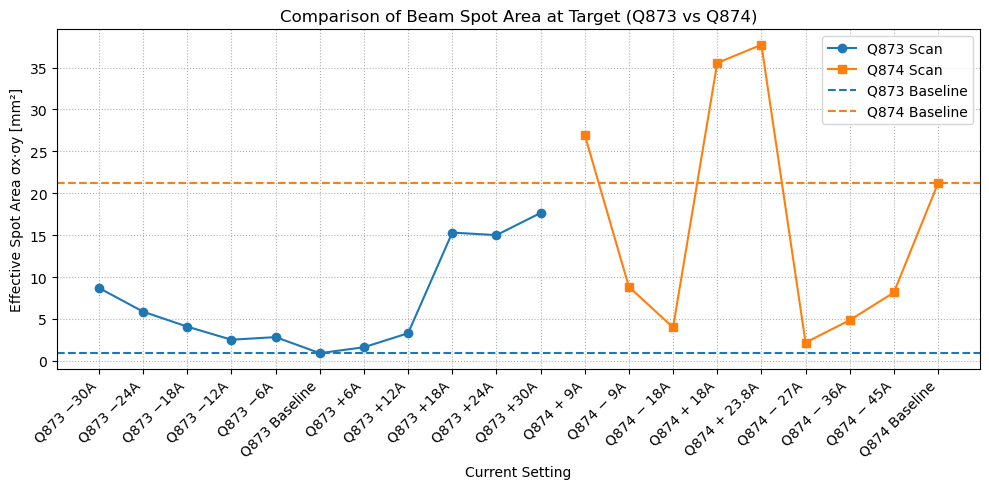

In [4]:

import pandas as pd
import matplotlib.pyplot as plt

# Load both scans
q873 = pd.read_csv("target_sigma_prediction_scaled_D_Q873.csv", index_col=0)
q874 = pd.read_csv("target_sigma_prediction_scaled_D_Q874.csv", index_col=0)

# Compute effective area (σx * σy) for each scan
q873["area_mm2"] = q873["sigx_mm"] * q873["sigy_mm"]
q874["area_mm2"] = q874["sigx_mm"] * q874["sigy_mm"]

# Find minima
best873 = q873["area_mm2"].idxmin()
best874 = q874["area_mm2"].idxmin()

print("=== Q873 Scan ===")
print(f"Best setting: {best873}")
print(f"  σx = {q873.loc[best873,'sigx_mm']:.2f} mm")
print(f"  σy = {q873.loc[best873,'sigy_mm']:.2f} mm")
print(f"  Area = {q873.loc[best873,'area_mm2']:.2f} mm²\n")

print("=== Q874 Scan ===")
print(f"Best setting: {best874}")
print(f"  σx = {q874.loc[best874,'sigx_mm']:.2f} mm")
print(f"  σy = {q874.loc[best874,'sigy_mm']:.2f} mm")
print(f"  Area = {q874.loc[best874,'area_mm2']:.2f} mm²\n")

print("Baseline Q873:", q873.loc["Q873 Baseline",["sigx_mm","sigy_mm","area_mm2"]])
print("Baseline Q874:", q874.loc["Q874 Baseline",["sigx_mm","sigy_mm","area_mm2"]])

# --- Plot for visual comparison ---
plt.figure(figsize=(10,5))
plt.plot(q873.index, q873["area_mm2"], marker="o", label="Q873 Scan")
plt.plot(q874.index, q874["area_mm2"], marker="s", label="Q874 Scan")
plt.axhline(q873.loc["Q873 Baseline","area_mm2"], color="C0", ls="--", label="Q873 Baseline")
plt.axhline(q874.loc["Q874 Baseline","area_mm2"], color="C1", ls="--", label="Q874 Baseline")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Effective Spot Area σx·σy [mm²]")
plt.xlabel("Current Setting")
plt.title("Comparison of Beam Spot Area at Target (Q873 vs Q874)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()


=== Q873 Scan ===
Best setting: Q873 Baseline
  σx = 1.30 mm
  σy = 0.71 mm
  Area = 0.92 mm²

Baseline Q873: σx = 1.30 mm, σy = 0.71 mm, Area = 0.92 mm²

=== Q874 Scan ===
Best setting: Q874 − 27A
  σx = 1.09 mm
  σy = 2.01 mm
  Area = 2.19 mm²

Baseline Q874: σx = 6.55 mm, σy = 3.24 mm, Area = 21.20 mm²

=== Q875 Scan ===
Best setting: Q875 Baseline
  σx = 2.05 mm
  σy = 1.53 mm
  Area = 3.14 mm²

Baseline Q875: σx = 2.05 mm, σy = 1.53 mm, Area = 3.14 mm²



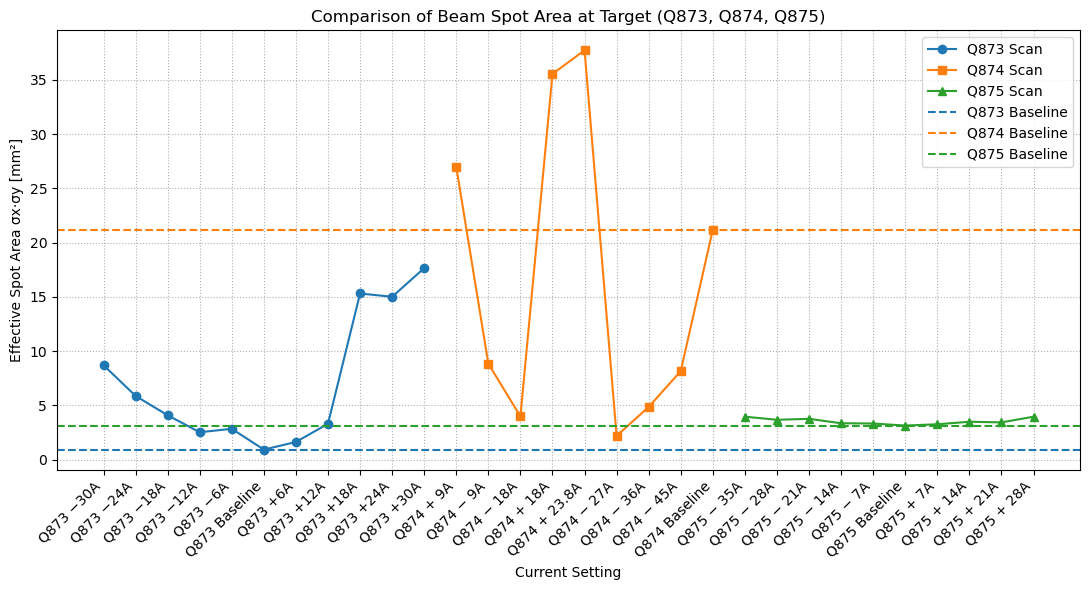

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Utility to auto-detect correct column names ---
def detect_columns(df):
    cols = [c.lower().replace(" ", "").replace("@target", "") for c in df.columns]
    sigx_col = None
    sigy_col = None
    for c, orig in zip(cols, df.columns):
        if "sigx" in c or "σx" in c:
            sigx_col = orig
        elif "sigy" in c or "σy" in c:
            sigy_col = orig
    if not sigx_col or not sigy_col:
        raise KeyError("Could not find σx or σy columns automatically.")
    return sigx_col, sigy_col

# --- Load all three scans ---
q873 = pd.read_csv("target_sigma_prediction_scaled_D_Q873.csv", index_col=0)
q874 = pd.read_csv("target_sigma_prediction_scaled_D_Q874.csv", index_col=0)
q875 = pd.read_csv("target_sigma_prediction_scaled_D_Q875_flipPol.csv", index_col=0)

# --- Normalize column names and compute effective area for each ---
def add_area(df):
    sigx_col, sigy_col = detect_columns(df)
    df["sigx_mm"] = df[sigx_col].astype(float)
    df["sigy_mm"] = df[sigy_col].astype(float)
    df["area_mm2"] = df["sigx_mm"] * df["sigy_mm"]

for df in [q873, q874, q875]:
    add_area(df)

# --- Helper to find and print minima ---
def print_best(label, df, baseline_label):
    best = df["area_mm2"].idxmin()
    print(f"=== {label} Scan ===")
    print(f"Best setting: {best}")
    print(f"  σx = {df.loc[best,'sigx_mm']:.2f} mm")
    print(f"  σy = {df.loc[best,'sigy_mm']:.2f} mm")
    print(f"  Area = {df.loc[best,'area_mm2']:.2f} mm²\n")

    if baseline_label in df.index:
        base = df.loc[baseline_label]
        print(f"Baseline {label}: σx = {base['sigx_mm']:.2f} mm, "
              f"σy = {base['sigy_mm']:.2f} mm, "
              f"Area = {base['area_mm2']:.2f} mm²\n")
    else:
        print(f"(Baseline {baseline_label} not found in index)\n")

# --- Print best results for all three scans ---
print_best("Q873", q873, "Q873 Baseline")
print_best("Q874", q874, "Q874 Baseline")
print_best("Q875", q875, "Q875 Baseline")

# --- Plot for visual comparison ---
plt.figure(figsize=(11,6))
plt.plot(q873.index, q873["area_mm2"], marker="o", label="Q873 Scan")
plt.plot(q874.index, q874["area_mm2"], marker="s", label="Q874 Scan")
plt.plot(q875.index, q875["area_mm2"], marker="^", label="Q875 Scan")

# Add baselines as dashed lines
if "Q873 Baseline" in q873.index:
    plt.axhline(q873.loc["Q873 Baseline","area_mm2"], color="C0", ls="--", label="Q873 Baseline")
if "Q874 Baseline" in q874.index:
    plt.axhline(q874.loc["Q874 Baseline","area_mm2"], color="C1", ls="--", label="Q874 Baseline")
if "Q875 Baseline" in q875.index:
    plt.axhline(q875.loc["Q875 Baseline","area_mm2"], color="C2", ls="--", label="Q875 Baseline")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Effective Spot Area σx·σy [mm²]")
plt.xlabel("Current Setting")
plt.title("Comparison of Beam Spot Area at Target (Q873, Q874, Q875)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()



=== Optimum (predicted) for minimum σₓ(target) ===
Q873 ≈ -30.0 A
Q874 ≈ -33.0 A
Q875 ≈ -35.0 A
Predicted σₓ ≈ 2.656 mm


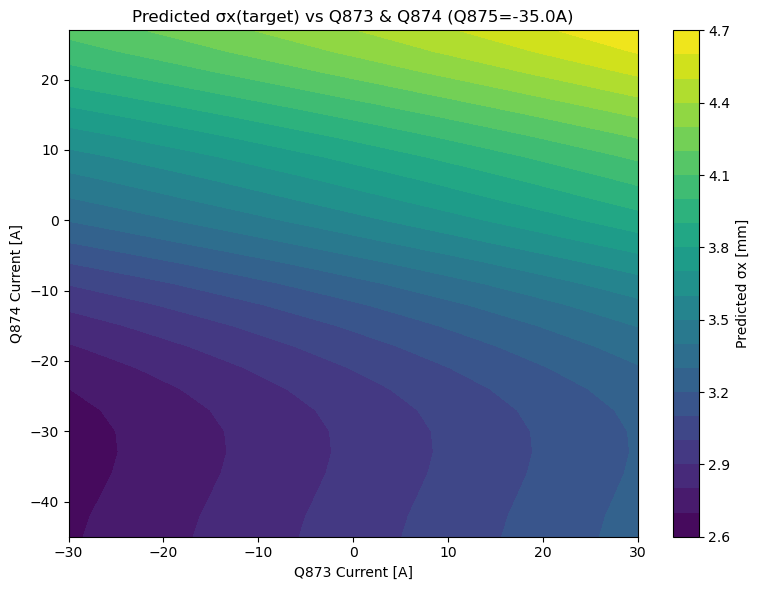

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import itertools
from scipy.interpolate import interp1d

# --------------------------------------------------------------
# Load predicted σx(target) data
# --------------------------------------------------------------
q873 = pd.read_csv("madx_pred_sigma_vs_current_HQ873_flipPol.csv", index_col=0)
q874 = pd.read_csv("madx_pred_sigma_vs_current_HQ874_flipPol.csv", index_col=0)
q875 = pd.read_csv("madx_pred_sigma_vs_current_HQ875_flipPol.csv", index_col=0)

def extract_sigma_mean(df):
    """Return currents [A] and average σx (mm) across H-plane wires."""
    xs = []
    ys = []
    for idx in df.index:
        # try to extract numeric current (handles 'HQ873 -12A' labels)
        try:
            val = float(idx.replace("A", "").replace("+", "").replace("−", "-").split()[-1])
        except Exception:
            val = 0.0
        xs.append(val)
        y = df.filter(like="H").mean(axis=1).loc[idx]
        ys.append(y)
    return np.array(xs), np.array(ys)

# extract scan data
I873, sx873 = extract_sigma_mean(q873)
I874, sx874 = extract_sigma_mean(q874)
I875, sx875 = extract_sigma_mean(q875)

# build interpolation functions
f873 = interp1d(I873, sx873, kind='cubic', fill_value="extrapolate")
f874 = interp1d(I874, sx874, kind='cubic', fill_value="extrapolate")
f875 = interp1d(I875, sx875, kind='cubic', fill_value="extrapolate")

# --------------------------------------------------------------
# Combine the three effects into an approximate joint model
# (weighted mean; you can tune the weights later)
# --------------------------------------------------------------
def combined_sigma(i873, i874, i875, w873=0.35, w874=0.45, w875=0.20):
    return w873*f873(i873) + w874*f874(i874) + w875*f875(i875)

# search grid
grid873 = np.linspace(min(I873), max(I873), 25)
grid874 = np.linspace(min(I874), max(I874), 25)
grid875 = np.linspace(min(I875), max(I875), 25)

best = {"σx": 1e9, "I873": None, "I874": None, "I875": None}
for i873, i874, i875 in itertools.product(grid873, grid874, grid875):
    val = combined_sigma(i873, i874, i875)
    if val < best["σx"]:
        best = {"σx": float(val), "I873": i873, "I874": i874, "I875": i875}

print("\n=== Optimum (predicted) for minimum σₓ(target) ===")
print(f"Q873 ≈ {best['I873']:.1f} A")
print(f"Q874 ≈ {best['I874']:.1f} A")
print(f"Q875 ≈ {best['I875']:.1f} A")
print(f"Predicted σₓ ≈ {best['σx']:.3f} mm")

# optional: visualize dependence on two magnets keeping the third fixed
import matplotlib.pyplot as plt
I873_vals, I874_vals = np.meshgrid(grid873, grid874)
Z = combined_sigma(I873_vals, I874_vals, best["I875"])

plt.figure(figsize=(8,6))
cp = plt.contourf(I873_vals, I874_vals, Z, levels=20, cmap="viridis")
plt.colorbar(cp, label="Predicted σx [mm]")
plt.xlabel("Q873 Current [A]")
plt.ylabel("Q874 Current [A]")
plt.title(f"Predicted σx(target) vs Q873 & Q874 (Q875={best['I875']:.1f}A)")
plt.tight_layout()
plt.show()


Q873 scan points: [-30. -24. -18. -12.  -6.   0.   6.  12.  18.  24.  30.]
Q874 scan points: [-45.  -36.  -27.  -18.   -9.    0.    9.   18.   23.8]
Q875 scan points: [-35. -28. -21. -14.  -7.   0.   7.  14.  21.  28.]

=== Global Predicted Optimum (Min σx at Target) ===
Q873 ≈ -6.7 A
Q874 ≈ -26.7 A
Q875 ≈ -28.6 A
Predicted σx(target) ≈ 4.212 mm


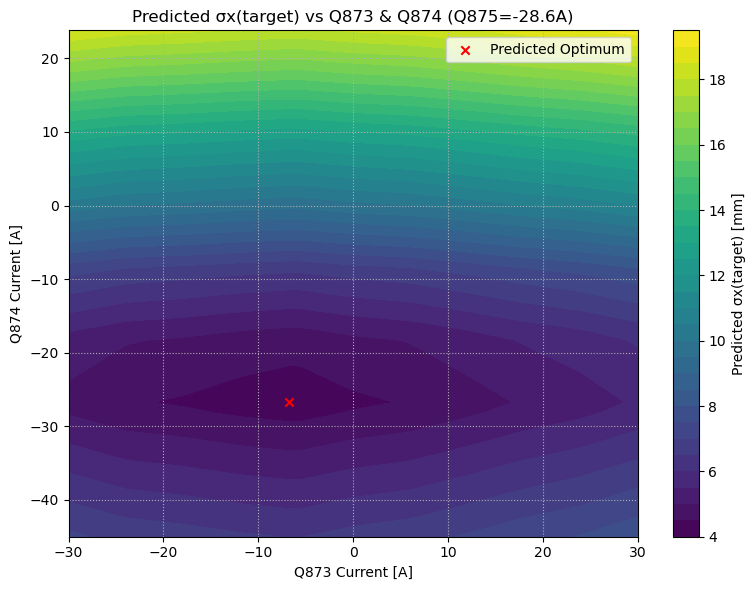

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# =========================================================
# Helper: Extract numeric current from label text
# =========================================================
def extract_current(label):
    label = str(label).replace("−", "-").replace("–", "-").strip()
    if "baseline" in label.lower():
        return 0.0
    import re
    m = re.search(r"([+\-]\s*\d+(?:\.\d+)?)", label)
    if m:
        return float(m.group(1).replace(" ", ""))
    return 0.0

# =========================================================
# Helper: Detect σx, σy column names (robust to any variation)
# =========================================================
def detect_sigma_columns(df):
    colmap = {c.lower().replace(" ", "").replace("@target", ""): c for c in df.columns}
    sigx_col = None
    sigy_col = None
    for k, v in colmap.items():
        if "sigx" in k or "σx" in k:
            sigx_col = v
        elif "sigy" in k or "σy" in k:
            sigy_col = v
    if not sigx_col or not sigy_col:
        raise KeyError(f"Could not find sigma-x/y columns in {list(df.columns)}")
    return sigx_col, sigy_col

# =========================================================
# Load any target_sigma_prediction CSV and standardize columns
# =========================================================
def load_sigma_csv(path, tag):
    df = pd.read_csv(path, index_col=0)
    sigx_col, sigy_col = detect_sigma_columns(df)
    df["sigx_mm"] = df[sigx_col].astype(float)
    df["sigy_mm"] = df[sigy_col].astype(float)
    df["area_mm2"] = df["sigx_mm"] * df["sigy_mm"]
    df["current"] = [extract_current(i) for i in df.index]
    df = df.sort_values("current")
    print(f"{tag} scan points:", df["current"].values)
    return df

# =========================================================
# Load the 3 scans
# =========================================================
q873 = load_sigma_csv("target_sigma_prediction_scaled_D_Q873.csv", "Q873")
q874 = load_sigma_csv("target_sigma_prediction_scaled_D_Q874.csv", "Q874")
q875 = load_sigma_csv("target_sigma_prediction_scaled_D_Q875_flipPol.csv", "Q875")

# =========================================================
# Build interpolators (for σx; can be changed to 'area_mm2' for area minimization)
# =========================================================
def interp_sigma(df, key="sigx_mm"):
    x = np.array(df["current"].values, float)
    y = np.array(df[key].values, float)
    uniq_idx = np.unique(x, return_index=True)[1]
    x = x[uniq_idx]
    y = y[uniq_idx]
    if len(x) < 2:
        raise ValueError("Need at least two unique current points for interpolation.")
    return RegularGridInterpolator((x,), y, bounds_error=False, fill_value=None)

f873 = interp_sigma(q873, key="sigx_mm")
f874 = interp_sigma(q874, key="sigx_mm")
f875 = interp_sigma(q875, key="sigx_mm")

# =========================================================
# Generate a parameter grid
# =========================================================
I873_vals = np.linspace(min(q873["current"]), max(q873["current"]), 50)
I874_vals = np.linspace(min(q874["current"]), max(q874["current"]), 50)
I875_vals = np.linspace(min(q875["current"]), max(q875["current"]), 50)

grid_Q873, grid_Q874, grid_Q875 = np.meshgrid(I873_vals, I874_vals, I875_vals, indexing="ij")

sigma_pred = (
    f873(grid_Q873.flatten()) +
    f874(grid_Q874.flatten()) +
    f875(grid_Q875.flatten())
).reshape(grid_Q873.shape)

# =========================================================
# Find the global minimum σx(target)
# =========================================================
min_idx = np.unravel_index(np.nanargmin(sigma_pred), sigma_pred.shape)
best_Q873 = grid_Q873[min_idx]
best_Q874 = grid_Q874[min_idx]
best_Q875 = grid_Q875[min_idx]
best_sigma = sigma_pred[min_idx]

print("\n=== Global Predicted Optimum (Min σx at Target) ===")
print(f"Q873 ≈ {best_Q873:.1f} A")
print(f"Q874 ≈ {best_Q874:.1f} A")
print(f"Q875 ≈ {best_Q875:.1f} A")
print(f"Predicted σx(target) ≈ {best_sigma:.3f} mm")

# =========================================================
# 2D contour slice at best Q875
# =========================================================
slice_idx = np.abs(I875_vals - best_Q875).argmin()
plt.figure(figsize=(8,6))
plt.contourf(grid_Q873[:,:,slice_idx], grid_Q874[:,:,slice_idx], sigma_pred[:,:,slice_idx],
             levels=30, cmap="viridis")
plt.colorbar(label="Predicted σx(target) [mm]")
plt.title(f"Predicted σx(target) vs Q873 & Q874 (Q875={I875_vals[slice_idx]:.1f}A)")
plt.xlabel("Q873 Current [A]")
plt.ylabel("Q874 Current [A]")
plt.scatter(best_Q873, best_Q874, color='red', marker='x', label='Predicted Optimum')
plt.legend()
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()


=== Q873 Scan ===
Best setting: Q873 Baseline
  σx = 1.30 mm
  σy = 0.71 mm
  Area = 0.92 mm²

Baseline Q873: σx = 1.30 mm, σy = 0.71 mm, Area = 0.92 mm²

=== Q874 Scan ===
Best setting: Q874 − 27A
  σx = 1.09 mm
  σy = 2.01 mm
  Area = 2.19 mm²

Baseline Q874: σx = 6.55 mm, σy = 3.24 mm, Area = 21.20 mm²

=== Q875 Scan ===
Best setting: Q875 Baseline
  σx = 2.05 mm
  σy = 1.53 mm
  Area = 3.14 mm²

Baseline Q875: σx = 2.05 mm, σy = 1.53 mm, Area = 3.14 mm²

=== Q873+Q874 Scan ===
Best setting: Q873 +6A + Q874 +9A
  σx = 2.28 mm
  σy = 0.60 mm
  Area = 1.37 mm²

Baseline Q873+Q874: σx = 2.23 mm, σy = 0.95 mm, Area = 2.12 mm²



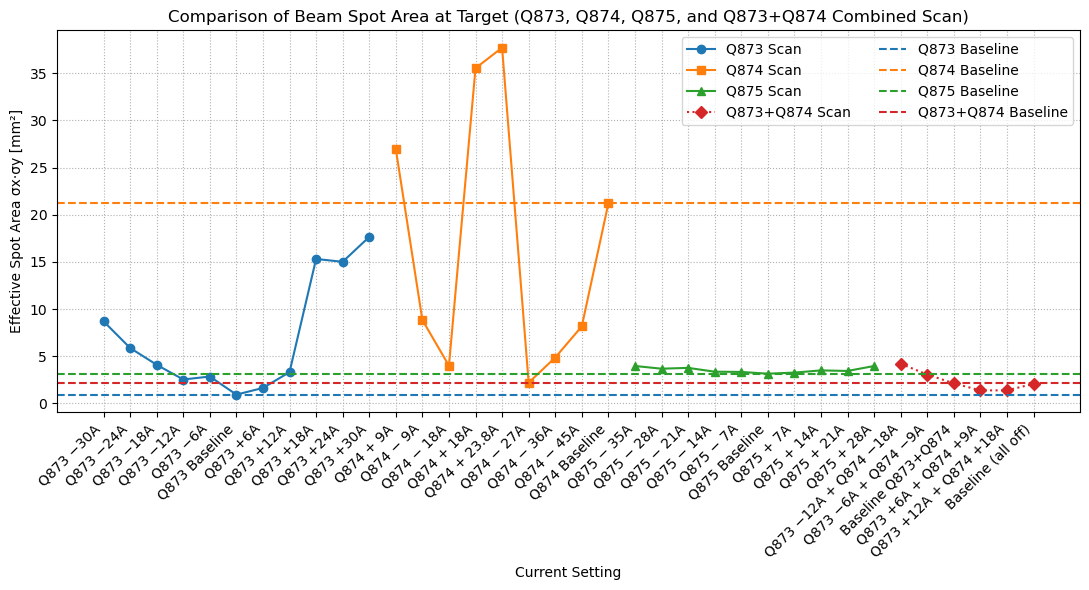

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Utility to auto-detect correct column names ---
def detect_columns(df):
    cols = [c.lower().replace(" ", "").replace("@target", "") for c in df.columns]
    sigx_col = None
    sigy_col = None
    for c, orig in zip(cols, df.columns):
        if "sigx" in c or "σx" in c:
            sigx_col = orig
        elif "sigy" in c or "σy" in c:
            sigy_col = orig
    if not sigx_col or not sigy_col:
        raise KeyError("Could not find σx or σy columns automatically.")
    return sigx_col, sigy_col


# --- Load all single-scan data ---
q873 = pd.read_csv("target_sigma_prediction_scaled_D_Q873.csv", index_col=0)
q874 = pd.read_csv("target_sigma_prediction_scaled_D_Q874.csv", index_col=0)
q875 = pd.read_csv("target_sigma_prediction_scaled_D_Q875_flipPol.csv", index_col=0)

# --- Normalize column names and compute effective area for each ---
def add_area(df):
    sigx_col, sigy_col = detect_columns(df)
    df["sigx_mm"] = df[sigx_col].astype(float)
    df["sigy_mm"] = df[sigy_col].astype(float)
    df["area_mm2"] = df["sigx_mm"] * df["sigy_mm"]

for df in [q873, q874, q875]:
    add_area(df)


# --- Build combined Q873+Q874 dataset manually (no CSV needed) ---
combined_data = {
    "Q873 −12A + Q874 −18A": [2.27, 1.85],
    "Q873 −6A + Q874 −9A": [2.18, 1.40],
    "Baseline Q873+Q874": [2.23, 0.95],
    "Q873 +6A + Q874 +9A": [2.28, 0.60],
    "Q873 +12A + Q874 +18A": [2.33, 0.59],
    "Baseline (all off)": [2.17, 0.95],
}

q873_q874 = pd.DataFrame.from_dict(
    combined_data,
    orient="index",
    columns=["sigx_mm", "sigy_mm"]
)
q873_q874["area_mm2"] = q873_q874["sigx_mm"] * q873_q874["sigy_mm"]


# --- Helper to find and print minima ---
def print_best(label, df, baseline_label):
    best = df["area_mm2"].idxmin()
    print(f"=== {label} Scan ===")
    print(f"Best setting: {best}")
    print(f"  σx = {df.loc[best,'sigx_mm']:.2f} mm")
    print(f"  σy = {df.loc[best,'sigy_mm']:.2f} mm")
    print(f"  Area = {df.loc[best,'area_mm2']:.2f} mm²\n")

    if baseline_label in df.index:
        base = df.loc[baseline_label]
        print(f"Baseline {label}: σx = {base['sigx_mm']:.2f} mm, "
              f"σy = {base['sigy_mm']:.2f} mm, "
              f"Area = {base['area_mm2']:.2f} mm²\n")
    else:
        print(f"(Baseline {baseline_label} not found in index)\n")


# --- Print best results for all scans ---
print_best("Q873", q873, "Q873 Baseline")
print_best("Q874", q874, "Q874 Baseline")
print_best("Q875", q875, "Q875 Baseline")
print_best("Q873+Q874", q873_q874, "Baseline Q873+Q874")


# --- Plot for visual comparison ---
plt.figure(figsize=(11,6))

plt.plot(q873.index, q873["area_mm2"], marker="o", label="Q873 Scan")
plt.plot(q874.index, q874["area_mm2"], marker="s", label="Q874 Scan")
plt.plot(q875.index, q875["area_mm2"], marker="^", label="Q875 Scan")

# Combined scan (dotted, diamond markers)
plt.plot(q873_q874.index, q873_q874["area_mm2"], marker="D", ls=":", color="C3", label="Q873+Q874 Scan")

# Baselines
if "Q873 Baseline" in q873.index:
    plt.axhline(q873.loc["Q873 Baseline","area_mm2"], color="C0", ls="--", label="Q873 Baseline")
if "Q874 Baseline" in q874.index:
    plt.axhline(q874.loc["Q874 Baseline","area_mm2"], color="C1", ls="--", label="Q874 Baseline")
if "Q875 Baseline" in q875.index:
    plt.axhline(q875.loc["Q875 Baseline","area_mm2"], color="C2", ls="--", label="Q875 Baseline")
if "Baseline Q873+Q874" in q873_q874.index:
    plt.axhline(q873_q874.loc["Baseline Q873+Q874","area_mm2"], color="C3", ls="--", label="Q873+Q874 Baseline")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Effective Spot Area σx·σy [mm²]")
plt.xlabel("Current Setting")
plt.title("Comparison of Beam Spot Area at Target (Q873, Q874, Q875, and Q873+Q874 Combined Scan)")
plt.grid(True, ls=":")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()
